In [1]:
from functions import *


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import pandas as pd

from skimage.feature import blob_log
import skimage
import scipy.signal as signal

from apsg import *



microm2m = 1.0E-6
m2microm = 1.0E6
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
flight = 5.0  # sample-sensor distance
area = (0, 1400*microm2m, 0, 2000*microm2m)
shape = (1000,1000)
z = -flight*microm2m

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A


# generates x shallow sourcers
sourcers = 100
D_1 = np.random.normal(0, 10, sourcers)
I_1 = np.random.normal(0, 10, sourcers)
Q_1 = np.random.normal(20000, 5000, sourcers)
R_1 = ( np.random.normal(0.5, 0.2, sourcers) )*microm2m

Xc_1 = np.random.randint(30, 1370, sourcers)*microm2m
Yc_1 = np.random.randint(30, 1970, sourcers)*microm2m
Zc_1 = np.random.randint(1, 20, sourcers)*microm2m


# generates x deep sourcers
sourcers = 10
D_2 = np.random.normal(0, 180, sourcers)
I_2 = np.random.normal(0, 90, sourcers)
Q_2 = np.random.normal(20000, 5000, sourcers)
R_2 = ( np.random.normal(10.5, 0.1, sourcers) )*microm2m

Xc_2 = np.random.randint(30, 1370, sourcers)*microm2m
Yc_2 = np.random.randint(30, 1970, sourcers)*microm2m
Zc_2 = np.random.randint(500, 550, sourcers)*microm2m

# concat sources
D = np.concatenate((D_1, D_2))
I = np.concatenate((I_1, I_2))
Q = np.concatenate((Q_1, Q_2))
R = np.concatenate((R_1, R_2))

Xc = np.concatenate((Xc_1, Xc_2))
Yc = np.concatenate((Yc_1, Yc_2))
Zc = np.concatenate((Zc_1, Zc_2))


m = cartesian_components(D, I, Q, R)
M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)


In [3]:
# data vector direct model
d = np.matmul(M, m)

#apply noise
#error = 0.05   # % for the 'max amplitude method'
error = 5.0e-9 # nT for the 'fixed method'

d = noise(d, error=error, method='fixed')

# Reshape data vector for the map plot
d_= np.reshape(d, shape)

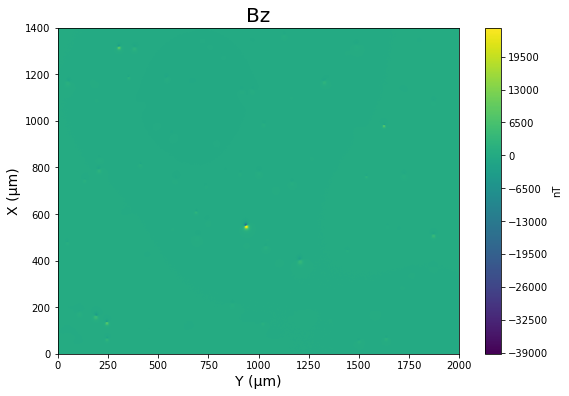

In [4]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm



# Plot data from the forward model
plt.figure(figsize=(9,6))
plt.contourf(x_plot, y_plot, d_*10**9, levels=300, cmap='viridis')
plt.colorbar(label='nT')

plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.show()

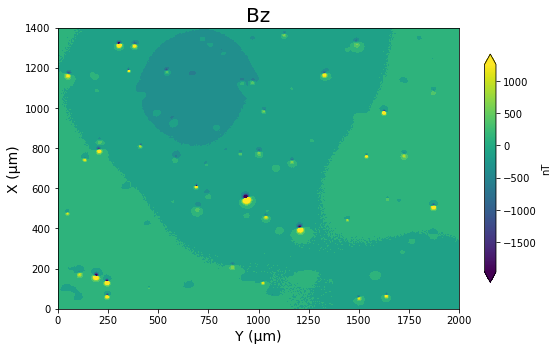

In [5]:
# Change the colorbar scale
# Plot data from the forward model
vmin=np.min(d_*10**9) * 0.05
vmax=np.max(d_*10**9) * 0.05


plt.figure(figsize=(9,6))
fig = plt.imshow(d_*10**9, cmap='viridis')
plt.clim(vmin, vmax)

plt.contourf(x_plot, y_plot, d_*10**9, levels=300, cmap='viridis', 
             vmin=vmin, vmax=vmax, extend='both')
color_bar = plt.colorbar(fig, label='nT', extend='both', shrink=0.7)

plt.gca().invert_yaxis()


plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)



plt.show()



In [6]:
X_ = np.reshape(X, shape)
Y_ = np.reshape(Y, shape)
Z_ = np.reshape(Z, shape)


# calculating derivatives using Fast Fourier Transform (FFT)

wx, wy, wz = wave_numbers(d_, X_, Y_)

ddx = x_derivative_fft(d_, wx, order=1)
ddy = y_derivative_fft(d_, wy, order=1)
ddz = z_derivative_fft(d_, wz, order=1)

# calculating derivatives (x and y) using Finite Differences (FD)
d_X, d_Y = (derivative_fd(d_, X_,Y_, order=1))


Text(0, 0.5, 'X (µm)')

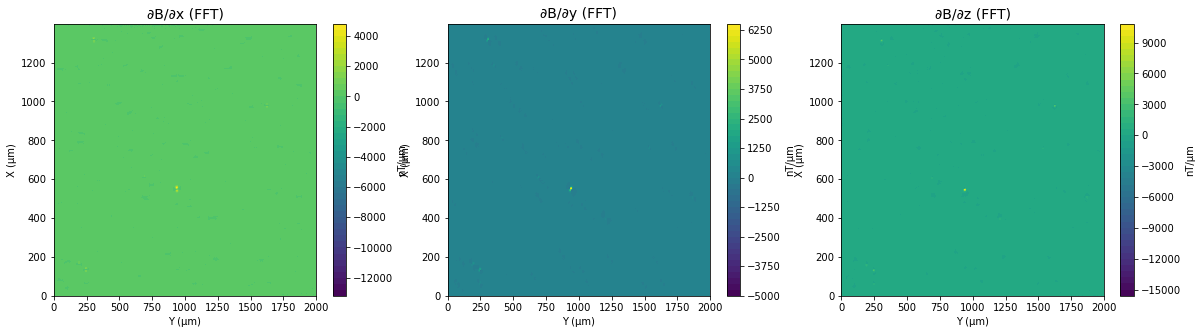

In [7]:
# plot FFT derivatives
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], ddx[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FFT)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot  = ax2.contourf(x_plot[::2], y_plot[::2], ddy[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FFT)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot  = ax3.contourf(x_plot[::2], y_plot[::2], ddz[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FFT)', fontsize=14)
ax3.set_xlabel('Y (µm)', fontsize=10)
ax3.set_ylabel('X (µm)', fontsize=10)

Text(0, 0.5, 'X (µm)')

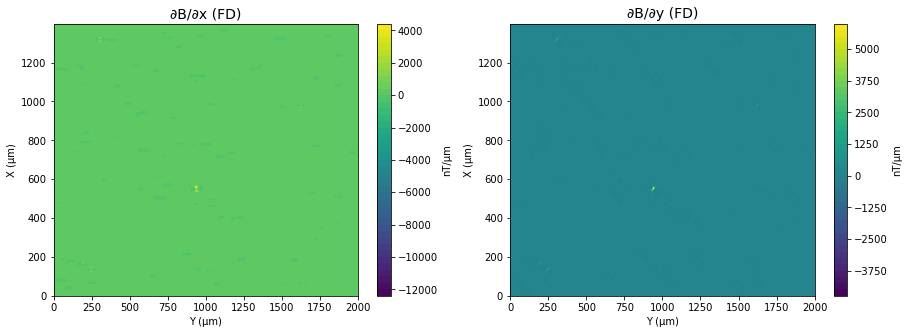

In [8]:
# plot FD derivatives
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], d_X[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FD)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot = ax2.contourf(x_plot[::2], y_plot[::2], d_Y[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FD)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

In [9]:
# Calculating the horizontal gradient (GH) using FFT e FD

Horiz_Grad_FD = Horiz_Grad(d_Y , d_X)
Horiz_Grad_FFT = Horiz_Grad(ddy, ddx)

Text(0, 0.5, 'X (µm)')

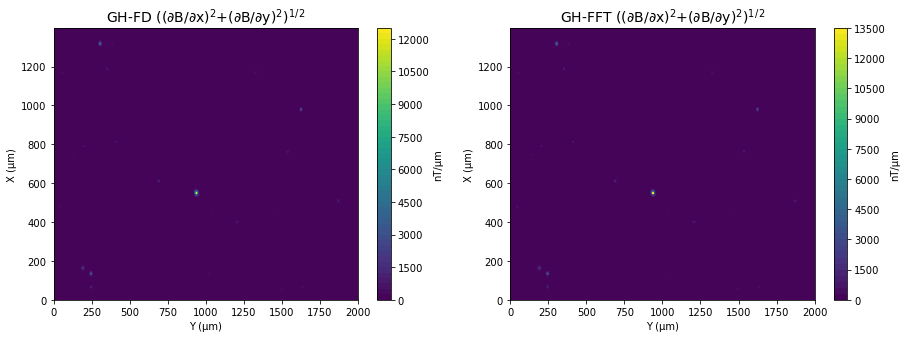

In [10]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], Horiz_Grad_FD[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT horizontal gradient 
ax2_plot = ax2.contourf(x_plot[::2], y_plot[::2], Horiz_Grad_FFT[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

In [11]:
# upward_continuation filtering --> to remove high frequency noise
height = 5.0      # delta_z upward continuation
delta_z = -height*microm2m
upward = upward_continuation(d_, delta_z, wz)


# upward_continuation --> used later to calculate the Z derivative by FD
delta_z1 = -(height-0.1)*microm2m
upward1 = upward_continuation(d_, delta_z1, wz)

delta_z2 = -(height+0.1)*microm2m
upward2 = upward_continuation(d_, delta_z2, wz)

Text(0, 0.5, 'X (µm)')

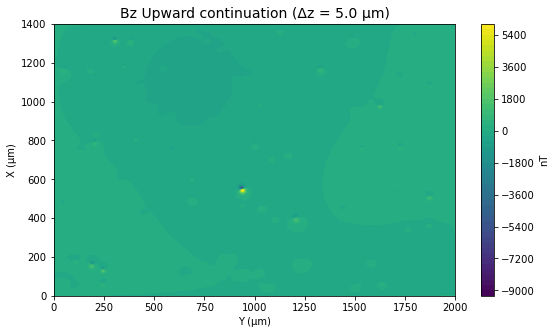

In [12]:
# upward continuation plot

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (upward)*10**9, levels=50, cmap='viridis')
plt.colorbar(label='nT')

plt.title('Bz Upward continuation (Δz = %s µm)'%height, fontsize=14)
plt.xlabel('Y (µm)', fontsize=10)
plt.ylabel('X (µm)', fontsize=10)



In [13]:
# New derivatives by FFT
ddy = y_derivative_fft(upward, wy)
ddx = x_derivative_fft(upward, wx)
ddz = z_derivative_fft(upward, wz)


Text(0, 0.5, 'X (µm)')

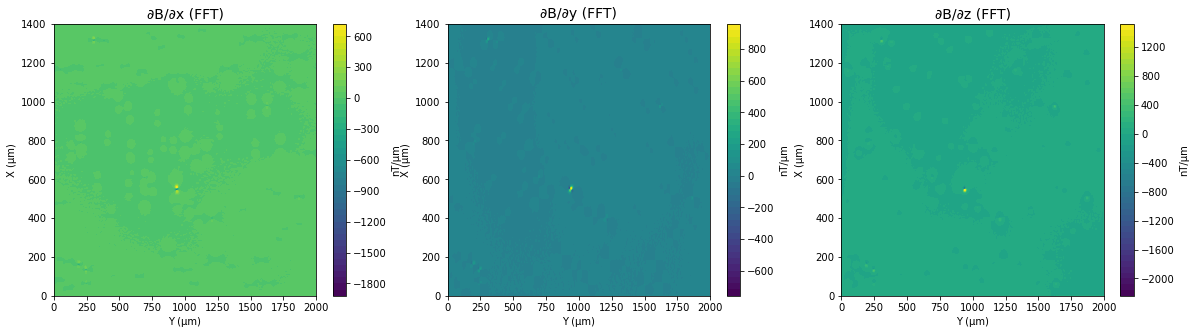

In [14]:
# Plot derivatives by FFT (after upward continuation)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot, y_plot, ddx*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FFT)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot  = ax2.contourf(x_plot, y_plot, ddy*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FFT)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot  = ax3.contourf(x_plot, y_plot, ddz*10**3, levels=50, cmap='viridis')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FFT)', fontsize=14)
ax3.set_xlabel('Y (µm)', fontsize=10)
ax3.set_ylabel('X (µm)', fontsize=10)


In [15]:
# New derivatives by FD
d_X, d_Y = (derivative_fd(upward, X_,Y_))
d_Z = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)

Text(0, 0.5, 'X (µm)')

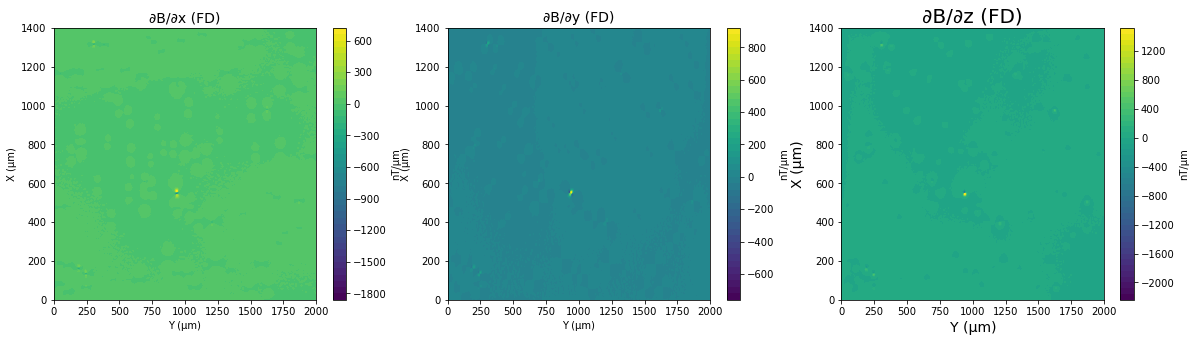

In [16]:
# Plot derivatives by FD (after upward continuation)
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot, y_plot, d_X*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FD)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot = ax2.contourf(x_plot, y_plot, d_Y*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FD)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot = ax3.contourf(x_plot, y_plot, d_Z*10**3, levels=50, cmap='viridis')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FD)', fontsize=20)
ax3.set_xlabel('Y (µm)', fontsize=14)
ax3.set_ylabel('X (µm)', fontsize=14)

In [17]:
# total gradient data
Total_Grad_FD = Total_Grad(d_Y , d_X, d_Z)
Total_Grad_FFT = Total_Grad(ddy, ddx, ddz)

Text(0, 0.5, 'X (µm)')

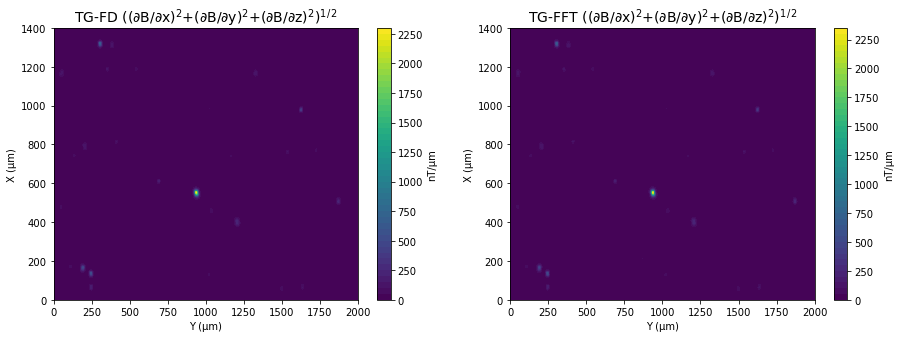

In [18]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

# plot FD total gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, Total_Grad_FD*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('TG-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$+(∂B/∂z)$^2$)$^1$$^/$$^2$', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT total gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, Total_Grad_FFT*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('TG-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$+(∂B/∂z)$^2$)$^1$$^/$$^2$', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

# Euler solver

Text(0, 0.5, 'Count')

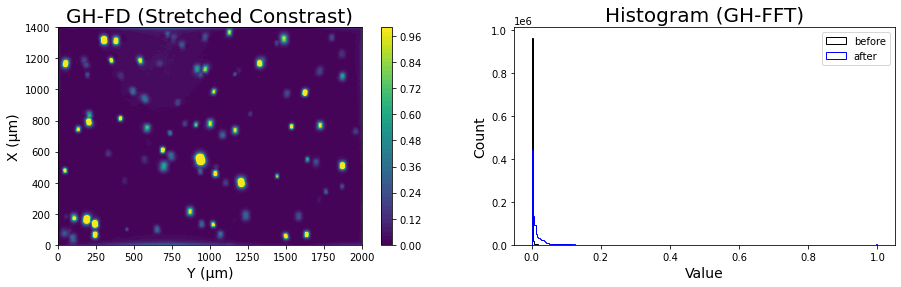

In [19]:
import skimage
import scipy.signal as signal

image =  Total_Grad_FD/Total_Grad_FD.max()

perc_min, perc_max = np.percentile(image, (20.5,99.5))
stretched_image = skimage.exposure.rescale_intensity(image, in_range=(perc_min, perc_max))


fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

ax1_plot = ax1.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='viridis')
ax1.set_title('GH-FD (Stretched Constrast)', fontsize=20)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax1_plot, ax=ax1)

ax2.hist(image.ravel(), bins=256, histtype='step', color='k', label='before');
ax2.hist(stretched_image.ravel(), bins=256, histtype='step', color='b', label='after');
ax2.legend()
ax2.set_title('Histogram (GH-FFT)', fontsize=20)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)


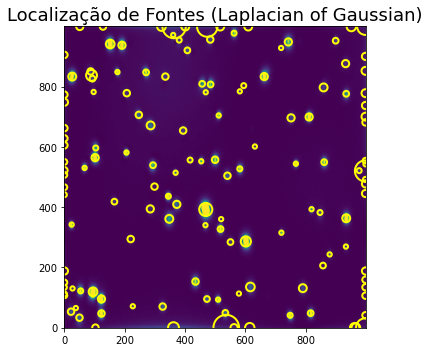

(88, 4)


()

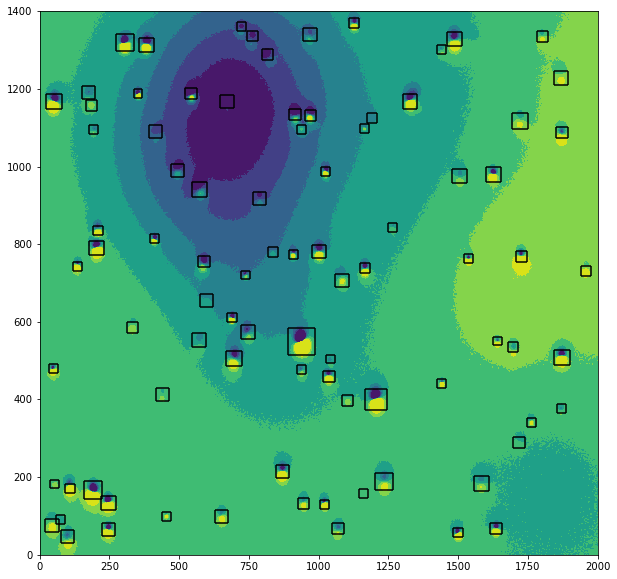

In [20]:
circles_FD, euler_windows_FD = sources_finder(stretched_image, threshold=0.01, min_sigma=5, max_sigma=30, num_sigma=30, overlap=1.0, radius_increment=0.1)
print(np.shape(euler_windows_FD))

Xc_FD, Yc_FD, Zc_FD, filtered_euler_windows_FD = solve_euler_windows(euler_windows_FD, X_, Y_, Z_, upward, d_X, d_Y, d_Z, delta_z, structural_index = 3.0)

import skimage
perc_min, perc_max = np.percentile(d_, (0.5,99.5))
view = skimage.exposure.rescale_intensity(d_, in_range=(perc_min, perc_max))
euler_windows_view(X_, Y_, Z_, view, filtered_euler_windows_FD, show_windows=False, color='k')


Euler Solutions:
      Xc (µm)    Yc (µm)  Zc (µm)
0    549.9940   937.9974   3.1187
1    980.0200  1624.9642   1.1715
2    401.0011  1206.0178   9.1044
3   1318.0107   304.9587   2.0745
4    509.8855  1871.0096   4.9439
..        ...        ...      ...
83  1118.3000  1205.0305  16.0306
84   287.8600  1721.3811   9.6038
85    82.3618    63.8891  22.4725
86   676.1634   634.3246  27.5720
87   161.2620  1158.1775   9.4378

[88 rows x 3 columns]

Original Positions:
    Xc (µm)  Yc (µm)  Zc (µm)
0    1131.0    917.0     14.0
1     548.0    572.0     19.0
2      65.0   1069.0     12.0
3     460.0   1036.0      6.0
4     101.0    653.0     12.0
..      ...      ...      ...
95    775.0    909.0      4.0
96    401.0   1206.0      9.0
97    731.0   1863.0     16.0
98    175.0    108.0     10.0
99    152.0   1357.0     17.0

[100 rows x 3 columns]



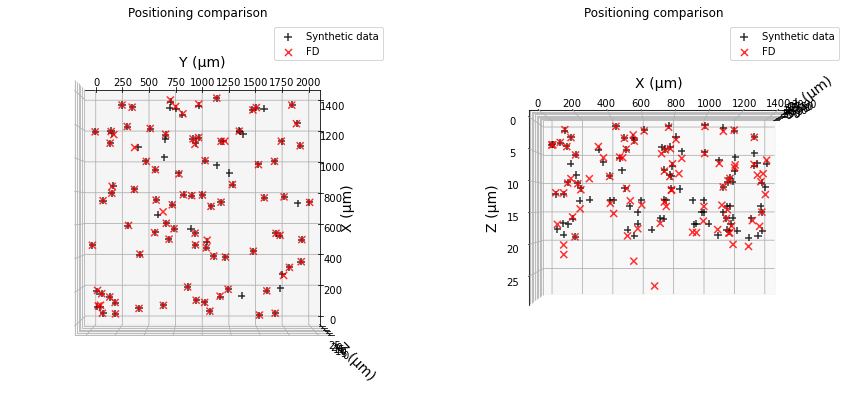

In [21]:
import pandas as pd
print('Euler Solutions:')
df1 = pd.DataFrame(data={'Xc (µm)': (np.round(Xc_FD*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc_FD*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc_FD*m2microm, decimals=4))
                       })

print(df1)
print()

print('Original Positions:')
df2 = pd.DataFrame(data={
                        'Xc (µm)': (np.round(Xc_1*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc_1*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc_1*m2microm, decimals=4))
                       })

print(df2)
print()

from mpl_toolkits.mplot3d import axes3d


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(Yc_1*m2microm, Xc_1*m2microm, Zc_1*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax1.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax1.set_title('Positioning comparison')
ax1.legend(loc='best')
ax1.invert_zaxis()

ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)
ax1.set_zlabel('Z (µm)', fontsize=14)

ax1.azim = -90
ax1.dist = 10
ax1.elev = 90




ax2.scatter(Yc_1*m2microm, Xc_1*m2microm, Zc_1*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax2.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax2.set_title('Positioning comparison')
ax2.legend(loc='best')
ax2.invert_zaxis()

ax2.set_xlabel('Y (µm)', fontsize=14)
ax2.set_ylabel('X (µm)', fontsize=14)
ax2.set_zlabel('Z (µm)', fontsize=14)

ax2.azim = 0
ax2.dist = 10
ax2.elev = 0

plt.show()





# Magnetic inversion using lest square method

Dec (°)  $\sigma D$ (°)  Inc (°)  $\sigma I$ (°)  m  ($A \cdot m^2$)  \
0 -17.0864          0.0015 -10.6392          0.0011        1.977916e-13   
1   6.1574          0.0098   6.7266          0.0070        1.721939e-14   
2 -11.0160          0.0090   2.0211          0.0064        9.793296e-14   
3  -6.7354          0.0050  -9.0336          0.0036        4.444372e-14   
4  -0.9349          0.0147  16.2590          0.0104        3.097407e-14   

   $\sigma m$ ($A \cdot m^2$)      Xc (µm)      Yc (µm)   Zc (µm)  
0                5.042427e-18   549.993994   937.997353  3.118728  
1                2.928728e-18   980.019974  1624.964171  1.171494  
2                1.534504e-17   401.001065  1206.017829  9.104381  
3                3.837901e-18  1318.010679   304.958716  2.074520  
4                7.478714e-18   509.885457  1871.009612  4.943929

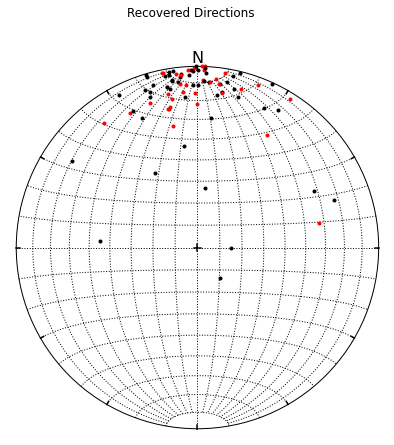

In [22]:
# Magnetic inversion using FD euler positions and magnetic data before the upward continuation

# Magnetic inversion using FD euler positions and magnetic data before the upward continuation
mx_FD_least, my_FD_least, mz_FD_least, M_FD_least, direct_model_FD_least = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)
D_FD_least, I_FD_least = directions(mx_FD_least, my_FD_least, mz_FD_least, plot=True)

#calculate momentum
momentum_FD_least = (np.sqrt(mx_FD_least**2 + my_FD_least**2 + mz_FD_least**2))


#Inversion uncertainties
# sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * error
sigma_noise = error
sigma_D_FD_least, sigma_I_FD_least, sigma_m_FD_least = uncertainties(sigma_noise, M_FD_least, mx_FD_least, my_FD_least, mz_FD_least)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_least, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_least, decimals=4)),
                        'Inc (°)': (np.round(I_FD_least, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_least, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_least),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_least),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)


# Model x Recoverd Data Comparison

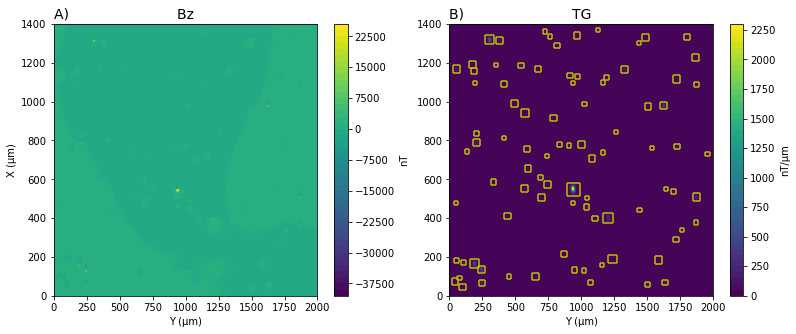

In [23]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(13,5))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, d_*10**9, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT')
ax1.set_title('A)                        Bz', fontsize=14, loc='left')
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT horizontal gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, Total_Grad_FD*1.0e3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('B)                        TG', fontsize=14, loc='left')
ax2.set_xlabel('Y (µm)', fontsize=10)
#ax2.set_ylabel('X (µm)', fontsize=10)

# plot isolated windows 
nx, ny = np.shape(d_)
y_step = (np.max(Y_)*m2microm - np.min(Y_)*m2microm) / (ny-1)
x_step = (np.max(X_)*m2microm - np.min(X_)*m2microm) / (nx-1)
color='y'
for i in range(np.shape(euler_windows_FD)[0]):
    x1 = int(euler_windows_FD[i,0]) * x_step
    x2 = int(euler_windows_FD[i,1]) * x_step
    y1 = int(euler_windows_FD[i,2]) * y_step
    y2 = int(euler_windows_FD[i,3]) * y_step

    plt.hlines(x1, y1, y2, color=color)
    plt.hlines(x2, y1, y2, color=color)
    plt.vlines(y1, x1, x2, color=color)
    plt.vlines(y2, x1, x2, color=color)


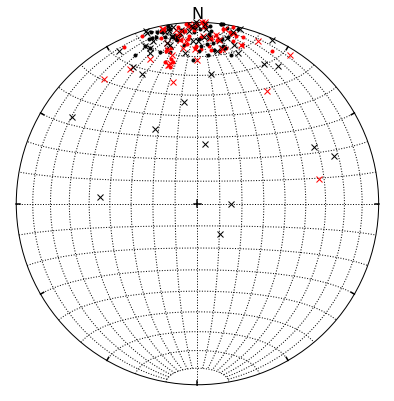

In [24]:
s = StereoNet(grid=True, legend=True)
settings['figsize'] = (7, 7)

for w in range (np.size(D_1)):
    if I_1[w] >= 0:
        symbol = '.'
        color = 'r'
    else:
        symbol = '.'
        color = 'k'

    if w == 0:
        s.line((Lin(float(D_1[w]), np.round(np.absolute(I_1[w])))), color=color, marker=symbol)
        #group.append((Lin(float(D[w]), np.round(np.absolute(I[w])))))
    else:
        s.line((Lin(float(D_1[w]), np.round(np.absolute(I_1[w])))), color=color, marker=symbol)
        #group.append((Lin(float(D[w]), np.round(np.absolute(I[w])))))
        
        
for k in range (np.size(D_FD_least)):
    if I_FD_least[k] >= 0:
        symbol = 'x'
        color = 'r'
    else:
        symbol = 'x'
        color = 'k'

    if k == 0:
        s.line((Lin(float(D_FD_least[k]), np.round(np.absolute(I_FD_least[k])))), color=color, marker=symbol)
        #group.append((Lin(float(D_FD_least[k]), np.round(np.absolute(I_FD_least[k])))))
    else:
        s.line((Lin(float(D_FD_least[k]), np.round(np.absolute(I_FD_least[k])))), color=color, marker=symbol)
        #group.append((Lin(float(D_FD_least[k]), np.round(np.absolute(I_FD_least[k])))))



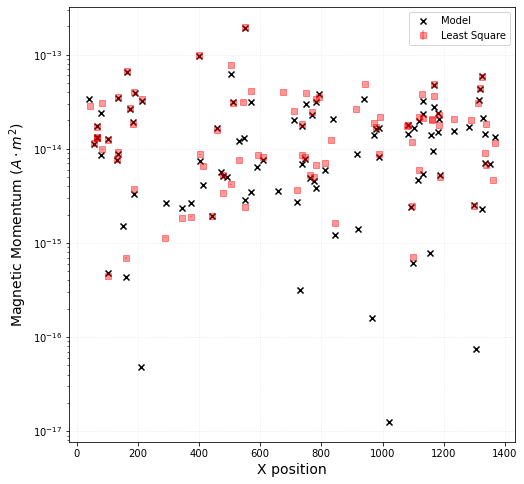

In [25]:
sources = np.copy(Xc_FD*m2microm)

real=(np.array(Q_1)*4/3*np.pi*np.array(R_1)**3)

plt.figure(figsize=(8,8))
plt.errorbar(sources, momentum_FD_least, sigma_m_FD_least, fmt='s', alpha=0.4, color='r', label='Least Square')


plt.scatter(np.array(Xc_1*m2microm), real, marker='x', color='k', label='Model')

plt.legend()
plt.grid(alpha=0.3, linestyle=':')

plt.xlabel('X position', fontsize=14);
plt.ylabel('Magnetic Momentum ($A \cdot m^2$)', fontsize=14);

plt.yscale('log')


## Forward Model and Errors

### Whole Area

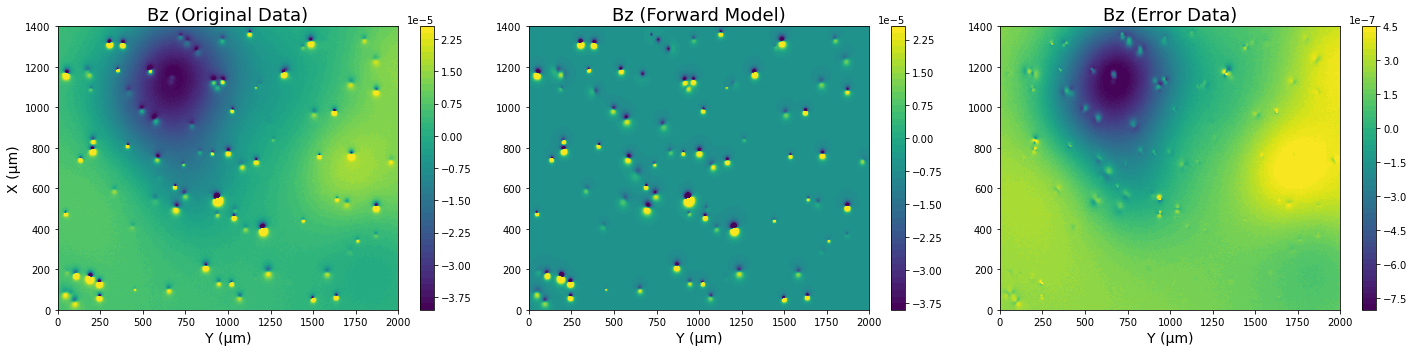

In [26]:
direct_model_FD_least = np.reshape(direct_model_FD_least, shape)

upward_direct_model_FD_least = upward_continuation(direct_model_FD_least, 0.0, wz)

original_data = np.copy(d_)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

perc_min, perc_max = np.percentile(original_data, (0.5,99.5))
original_data_view = skimage.exposure.rescale_intensity(original_data, in_range=(perc_min, perc_max))
ax4_plot = ax1.contourf(x_plot, y_plot, original_data, levels=50, cmap='viridis')
ax1_plot = ax1.contourf(x_plot, y_plot, original_data_view, levels=50, cmap='viridis')

plt.colorbar(ax4_plot, ax=ax1)
ax1.set_title('Bz (Original Data)', fontsize=18)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)


perc_min, perc_max = np.percentile(upward_direct_model_FD_least, (0.5,99.5))
direct_model_view = skimage.exposure.rescale_intensity(upward_direct_model_FD_least, in_range=(perc_min, perc_max))
ax5_plot = ax2.contourf(x_plot, y_plot, upward_direct_model_FD_least, levels=50, cmap='viridis')
ax2_plot = ax2.contourf(x_plot, y_plot, direct_model_view, levels=50, cmap='viridis')
plt.colorbar(ax5_plot, ax=ax2)
ax2.set_title('Bz (Forward Model)', fontsize=18)
ax2.set_xlabel('Y (µm)', fontsize=14)

error = original_data - upward_direct_model_FD_least
perc_min, perc_max = np.percentile(error, (0.5,99.5))
error_data_view = skimage.exposure.rescale_intensity(error, in_range=(perc_min, perc_max))
ax6_plot = ax3.contourf(x_plot, y_plot, error, levels=50, cmap='viridis')
ax3_plot = ax3.contourf(x_plot, y_plot, error_data_view, levels=50, cmap='viridis')
plt.colorbar(ax6_plot, ax=ax3)
ax3.set_title('Bz (Error Data)', fontsize=18)
ax3.set_xlabel('Y (µm)', fontsize=14)



plt.tight_layout()

R2:  0.9992926044459474


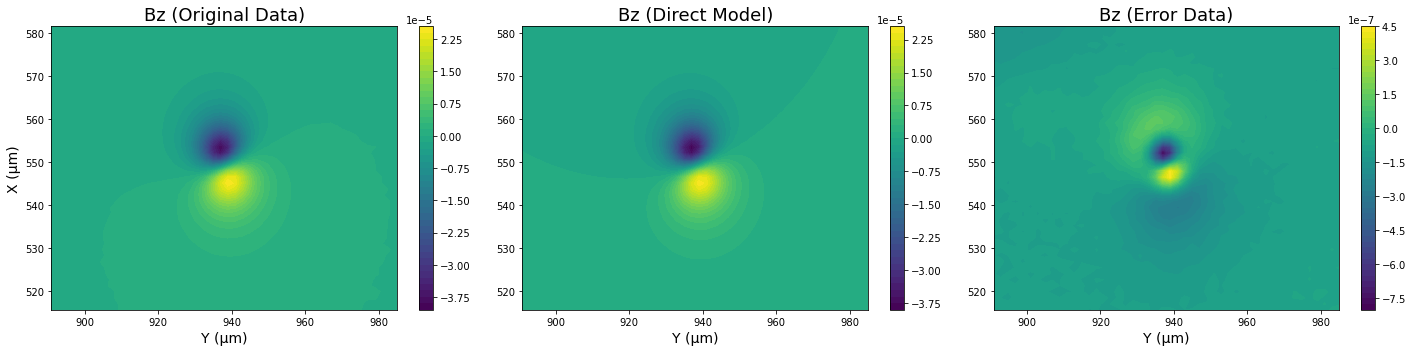

R2:  0.9985921206796223


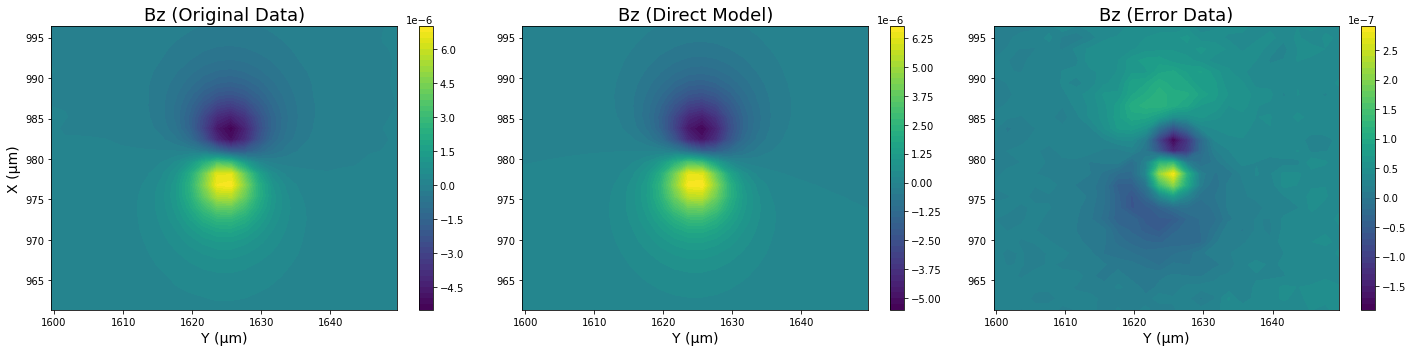

R2:  0.9993741467856163


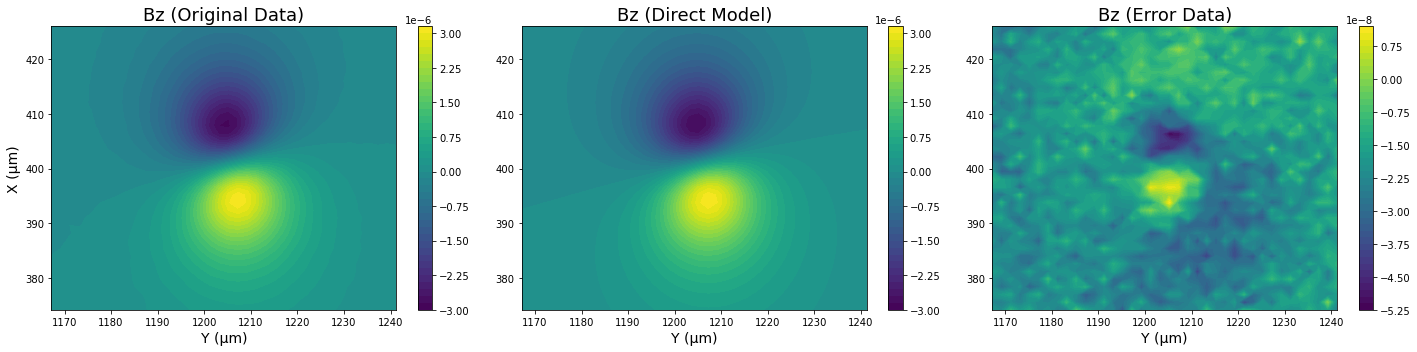

R2:  0.99721960754848


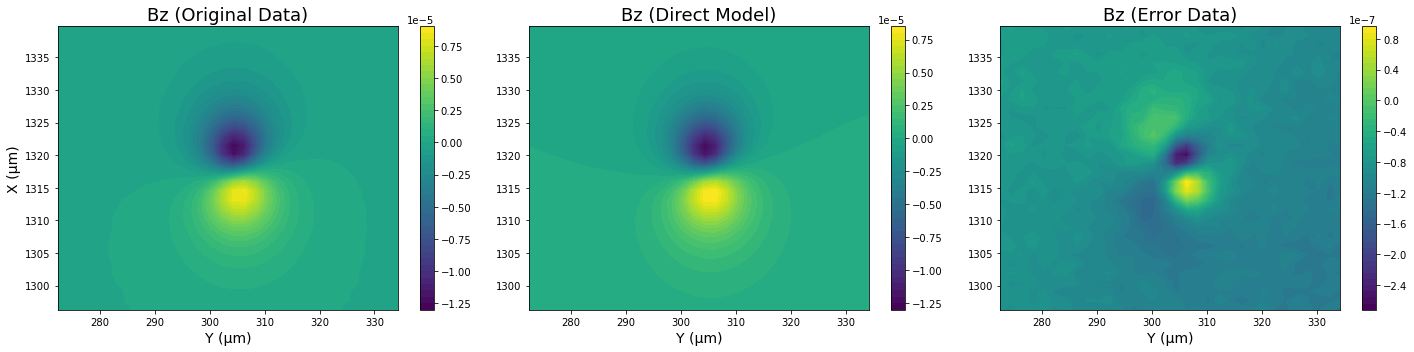

R2:  0.9945553406186469


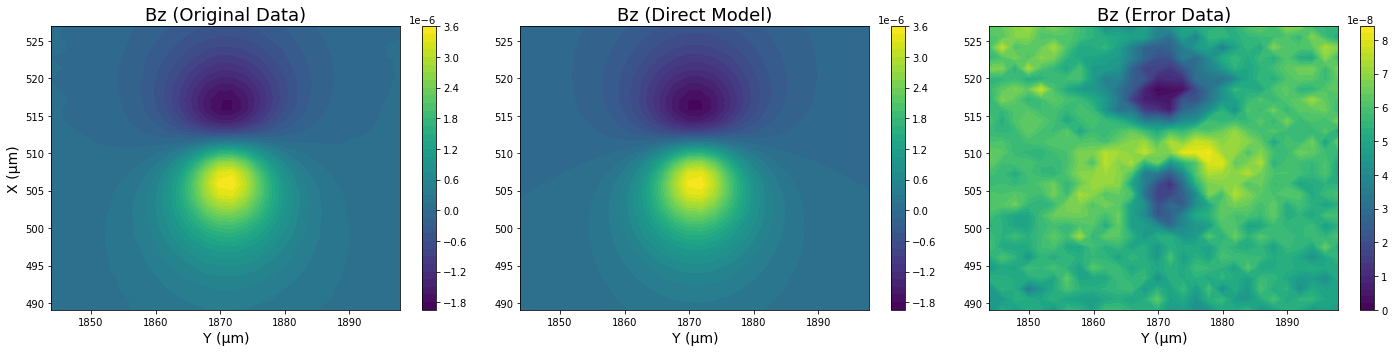

R2:  0.9982972281401037


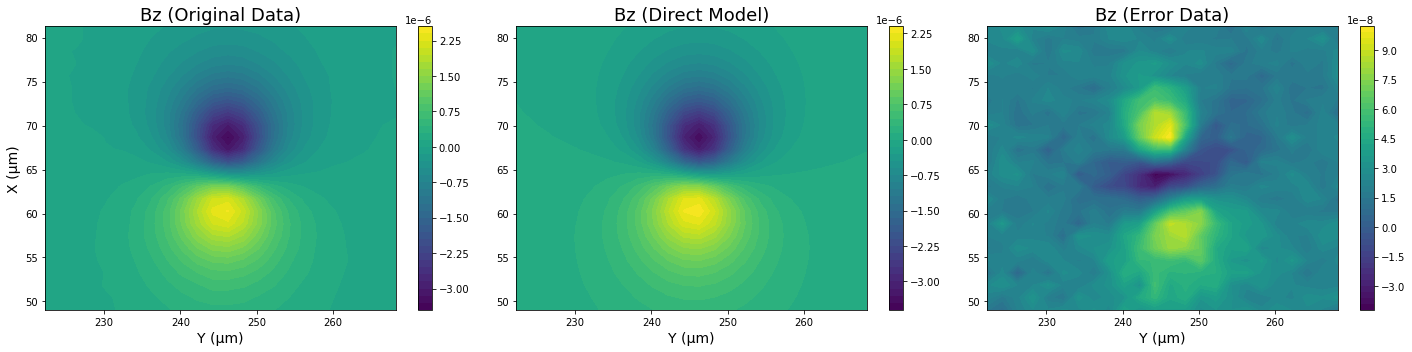

R2:  0.9667751140056752


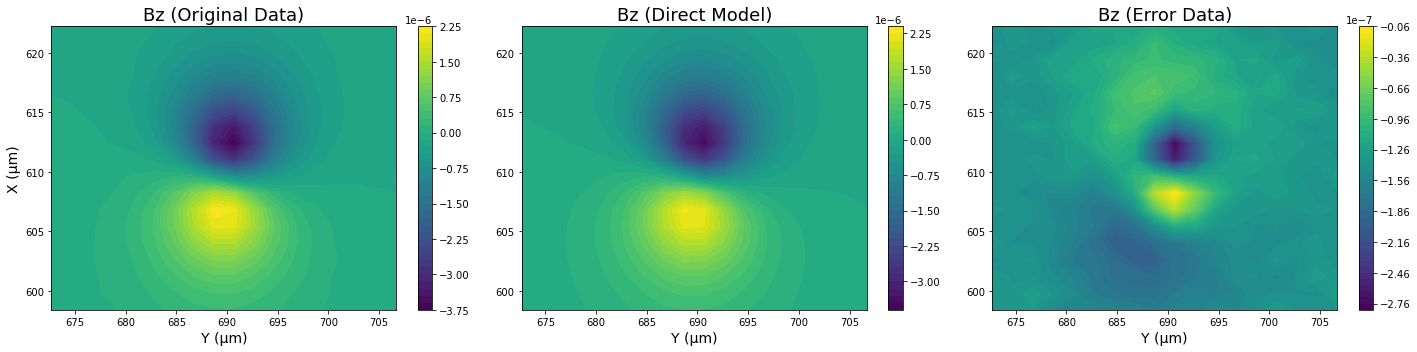

R2:  0.9987643214331833


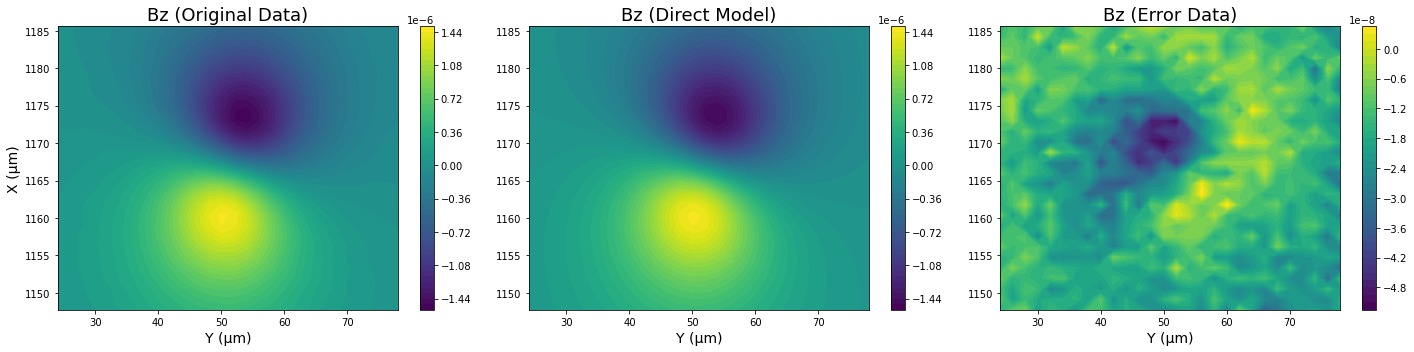

R2:  0.9616638597234382


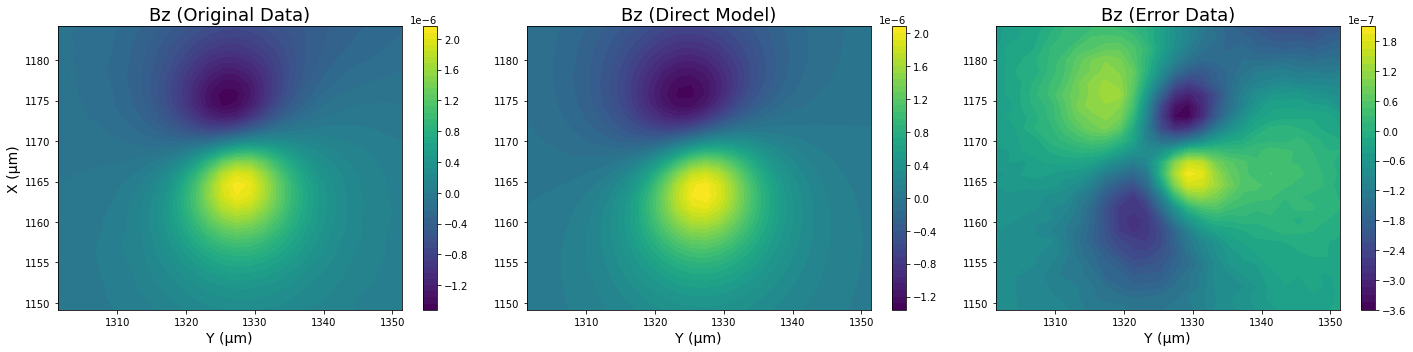

R2:  0.9962794761365048


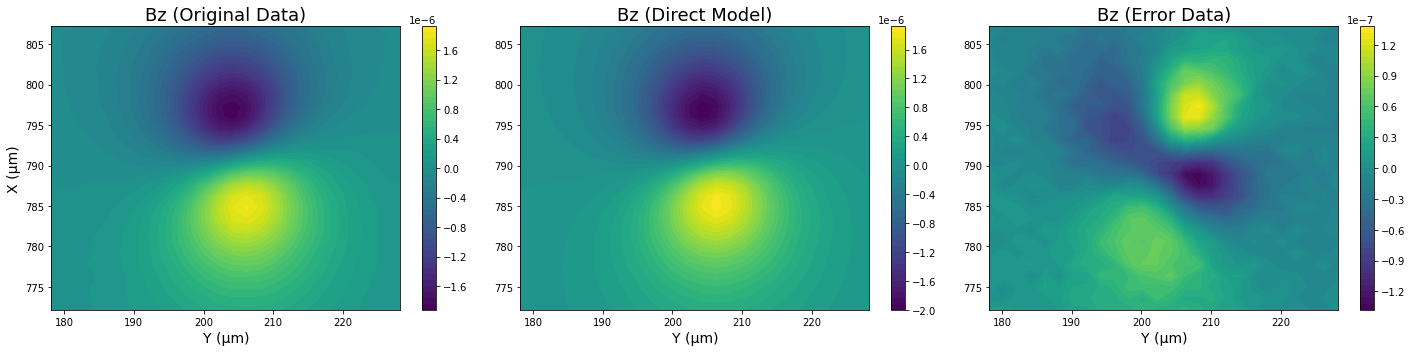

R2:  0.9038330749689286


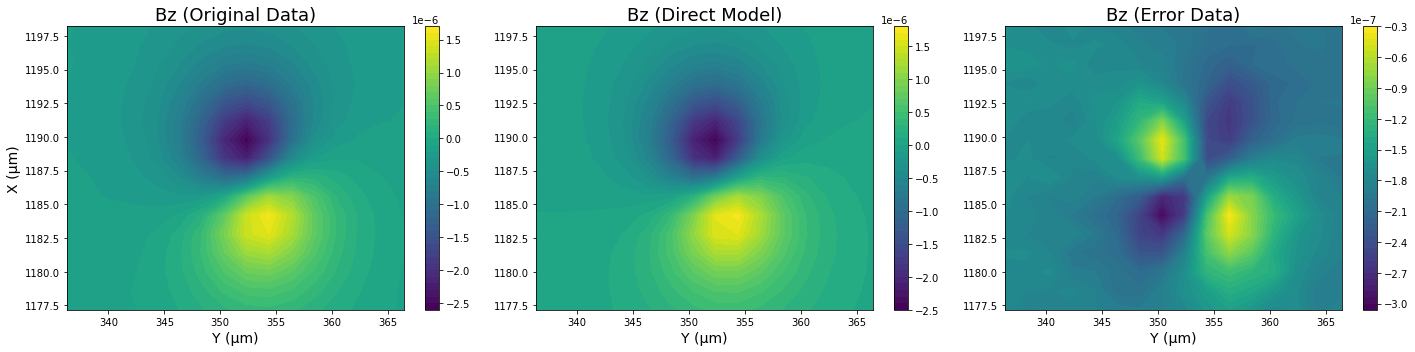

R2:  0.9955528724152345


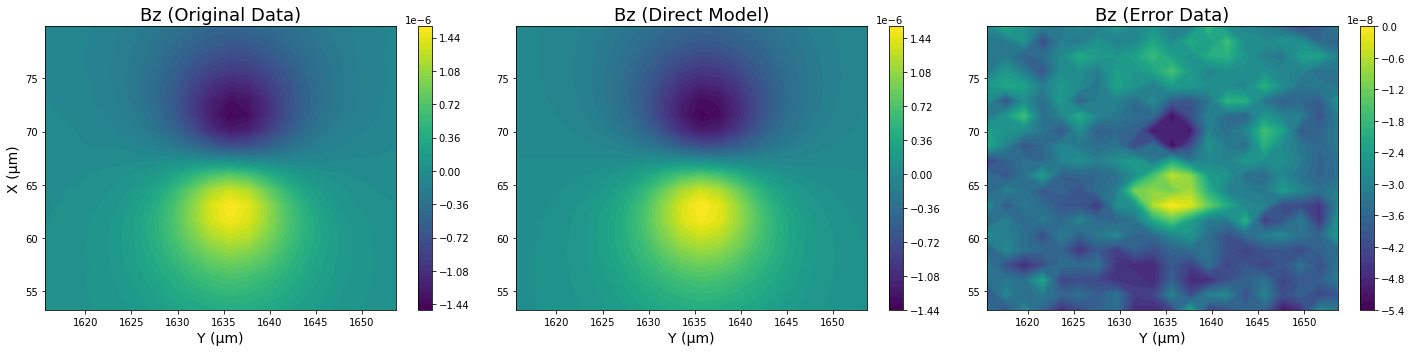

R2:  0.9242567527805343


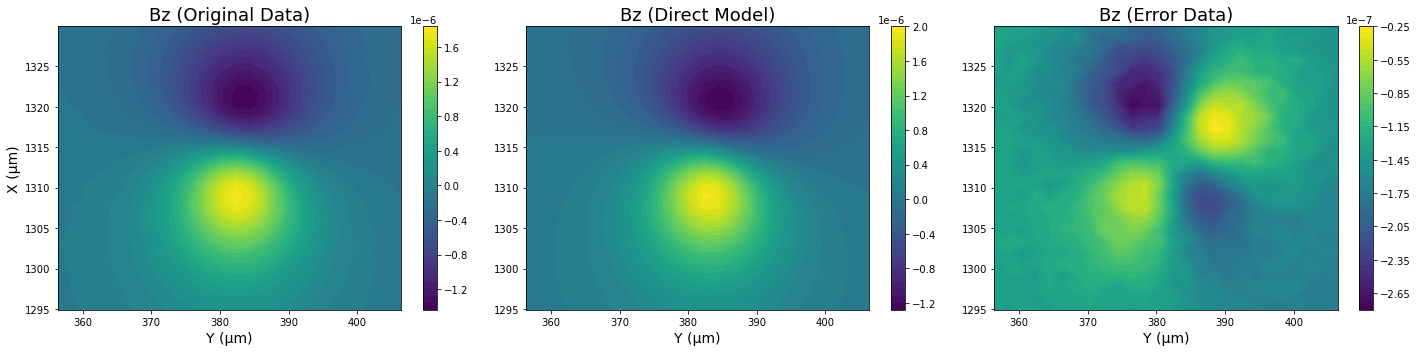

R2:  0.9228122324716048


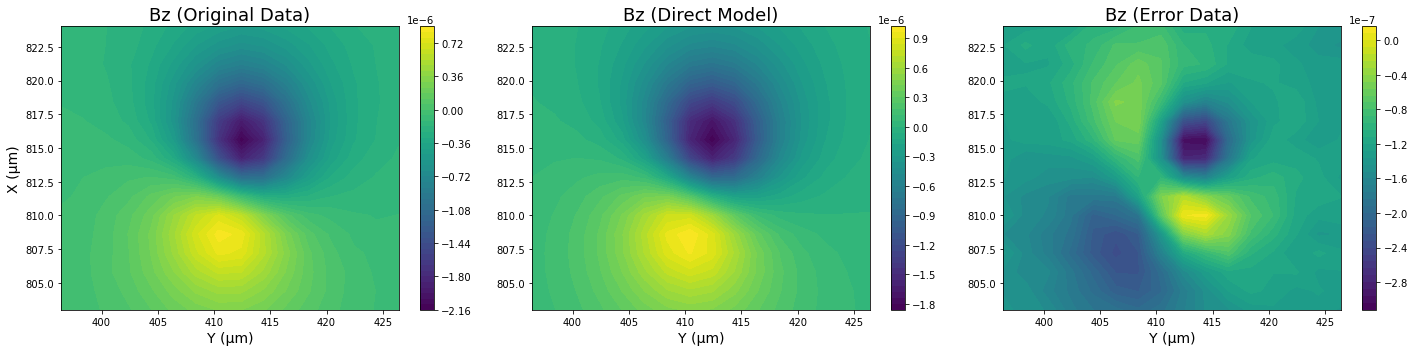

R2:  0.9842585012853816


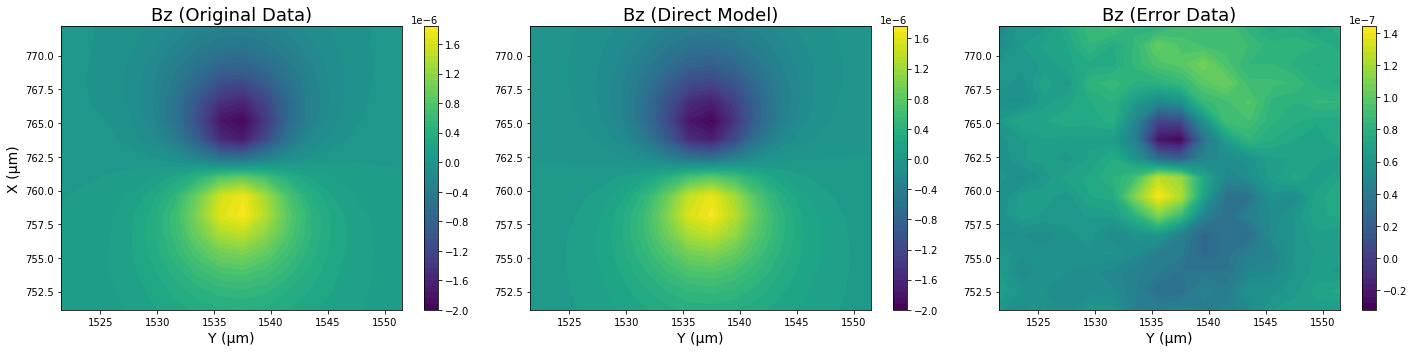

R2:  0.9979517116861365


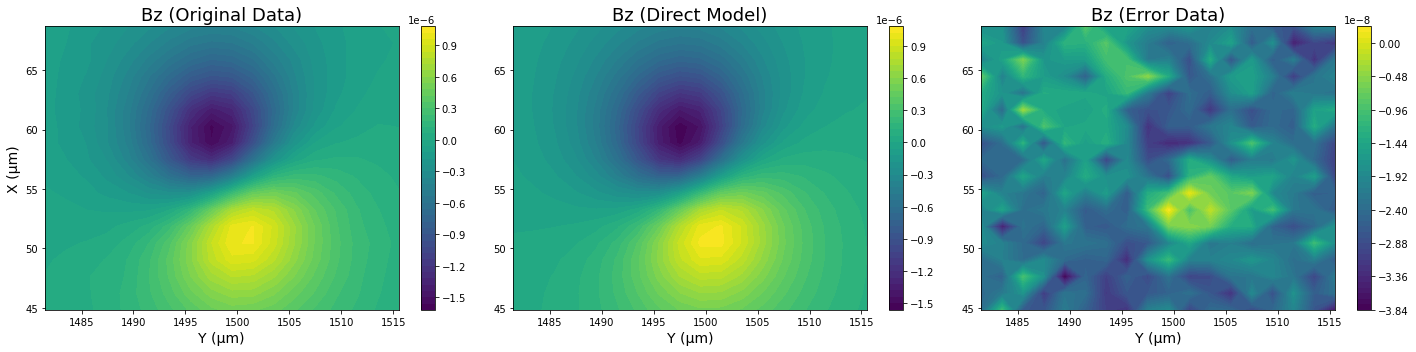

R2:  0.9992999618151728


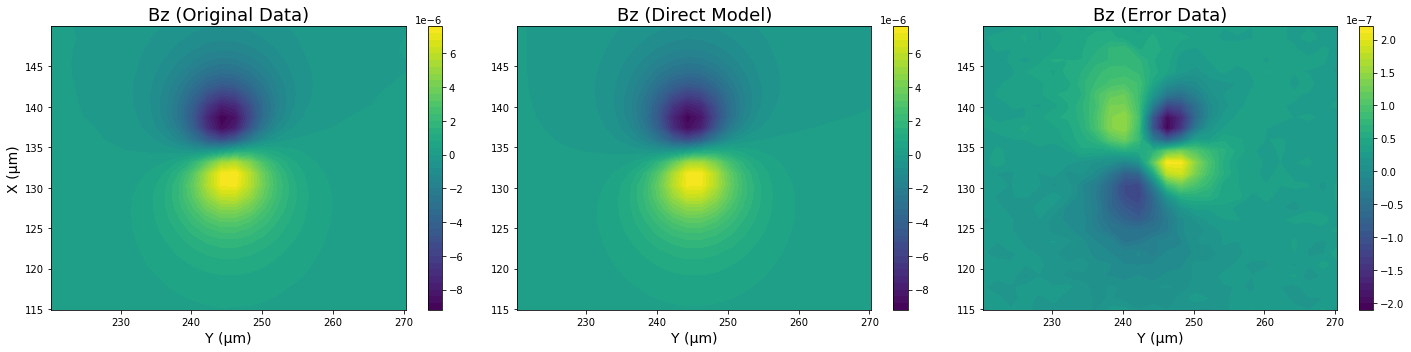

R2:  0.9883983078469643


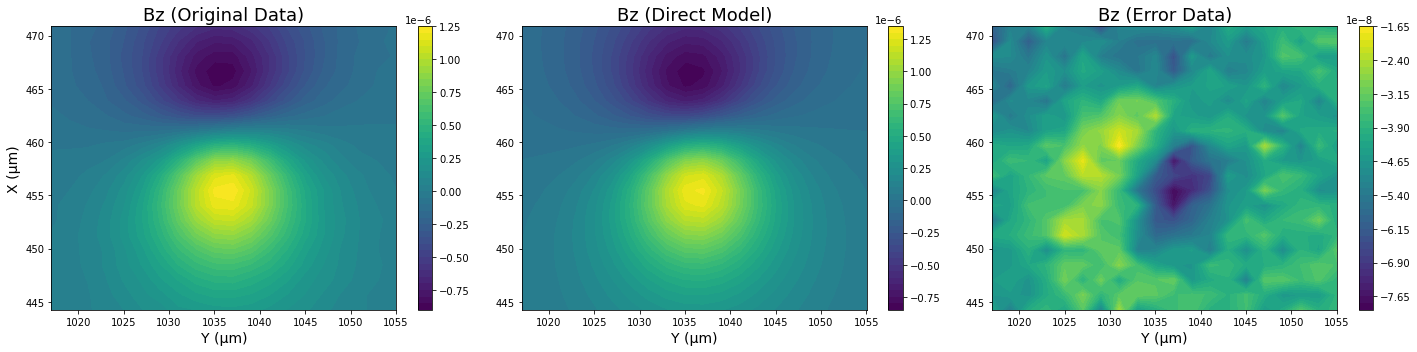

R2:  0.9994614002201426


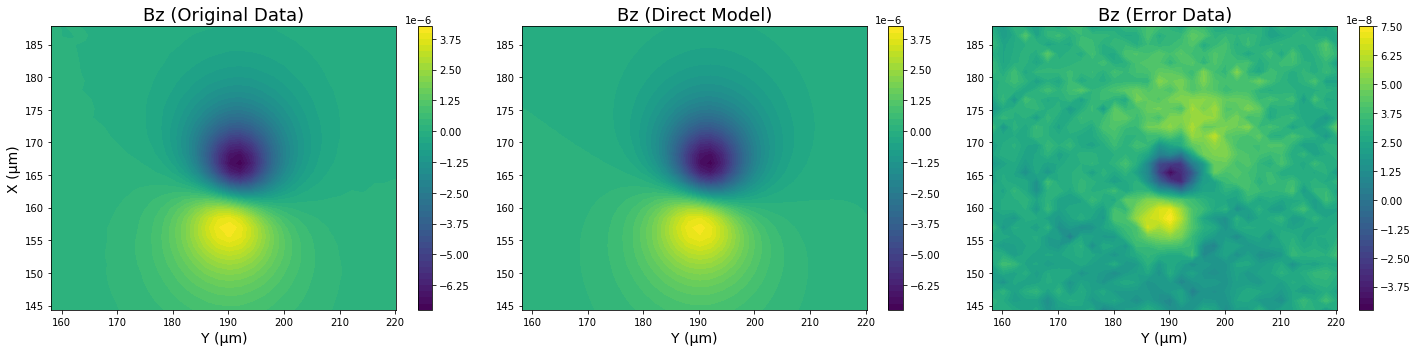

R2:  0.99165245795607


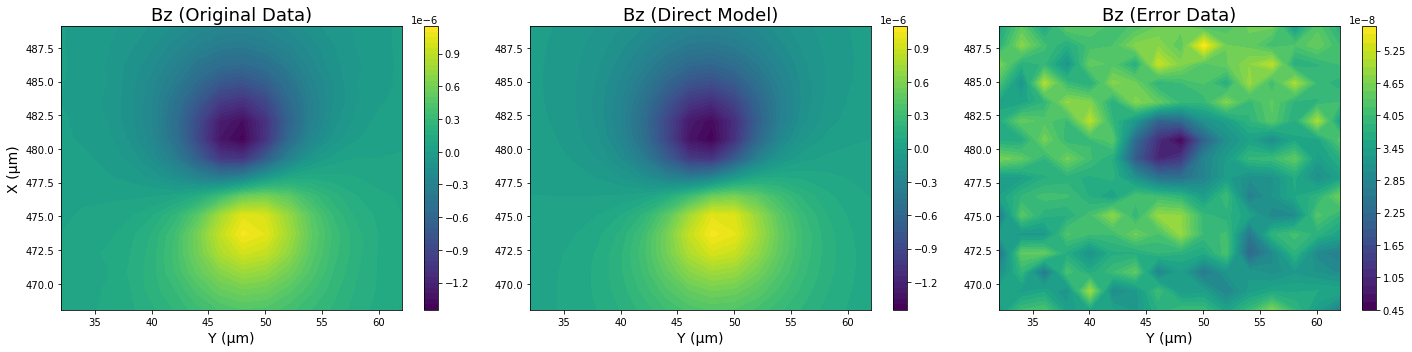

R2:  0.9972992055798862


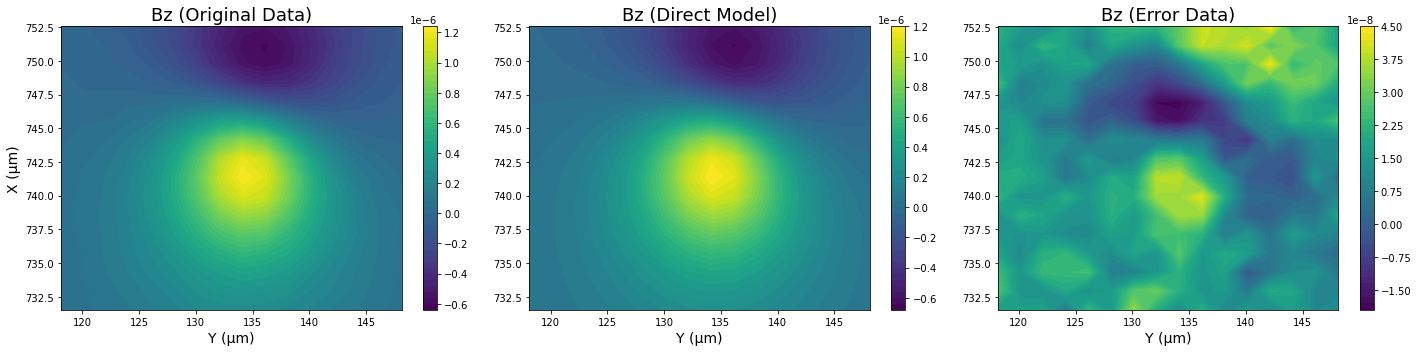

R2:  0.9990347971022898


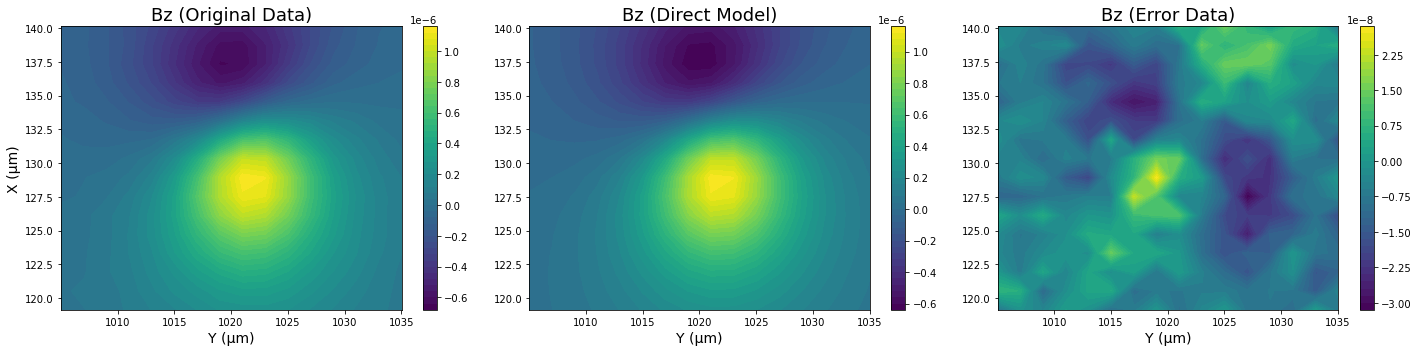

R2:  0.9924748571942552


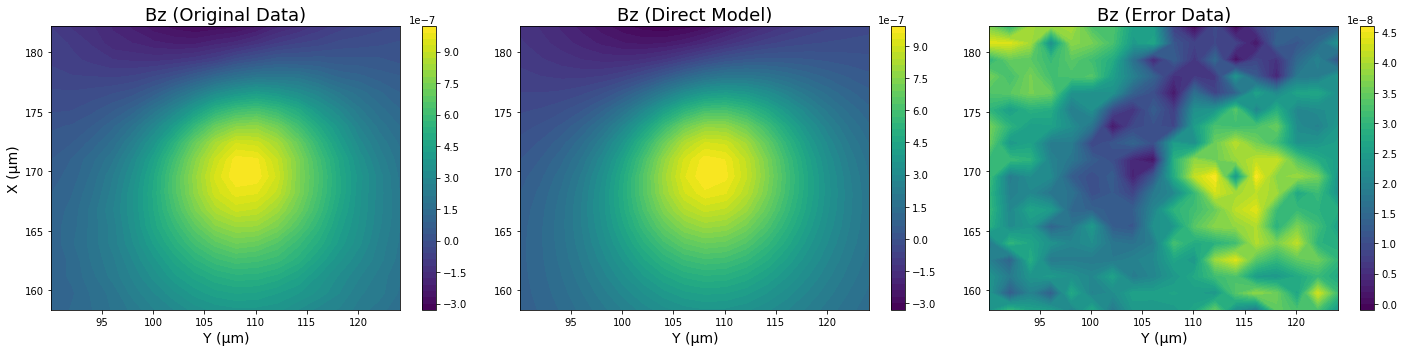

R2:  -0.08793134316589968


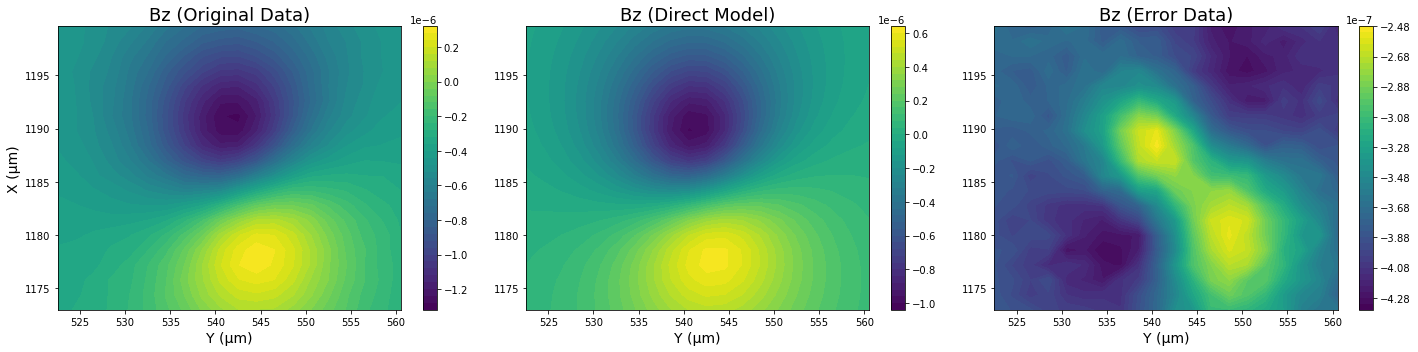

R2:  0.8930844899567842


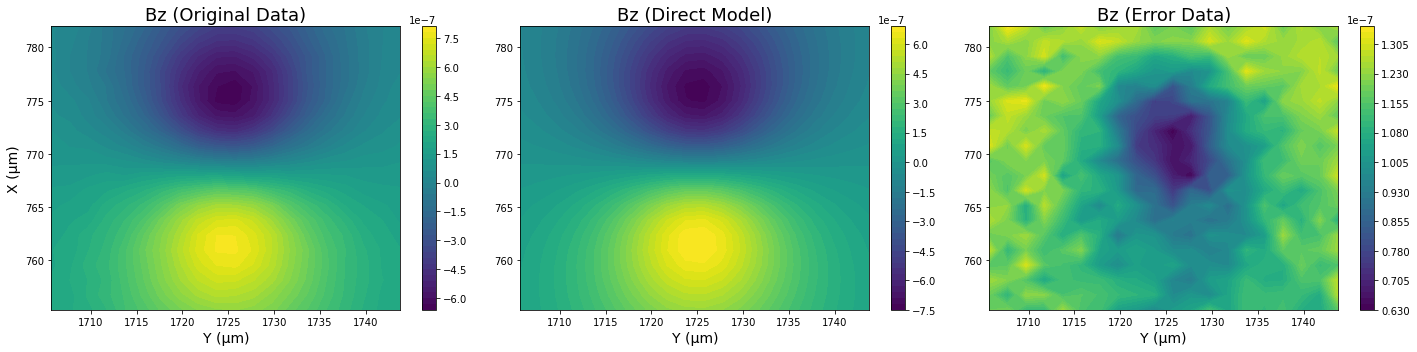

R2:  0.9666153892372994


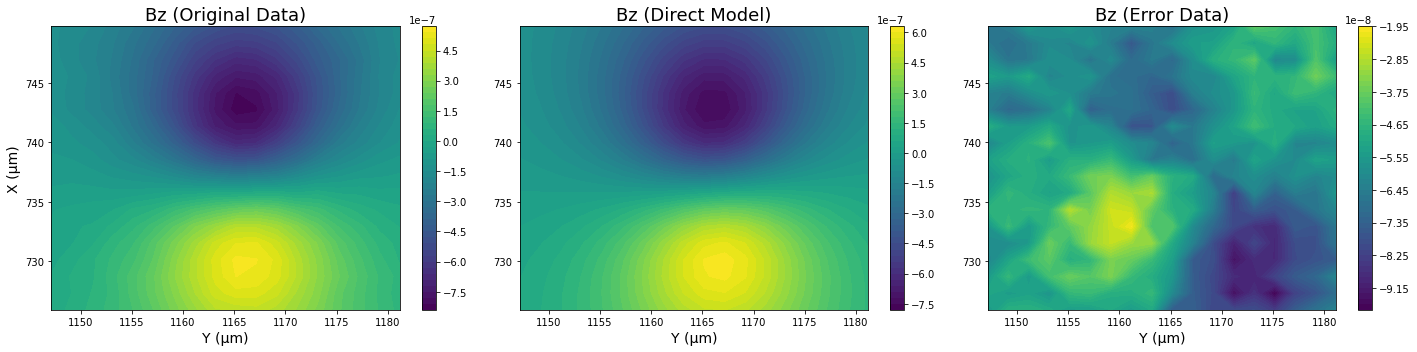

R2:  0.9983806233173177


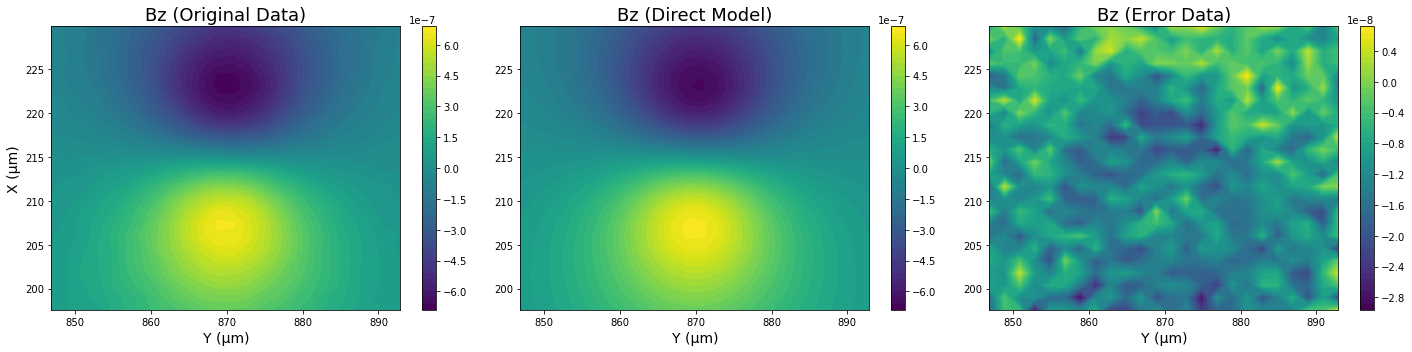

R2:  0.8307288304623581


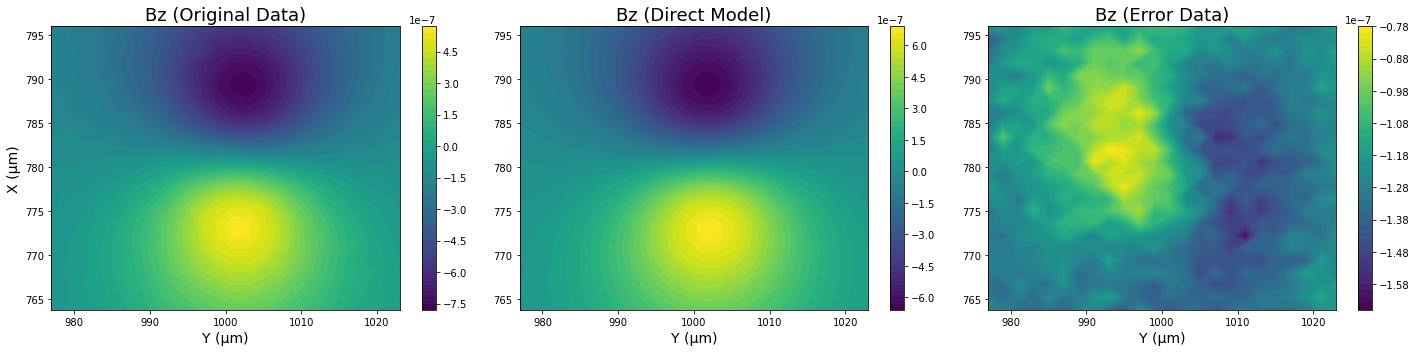

R2:  0.6730268686038029


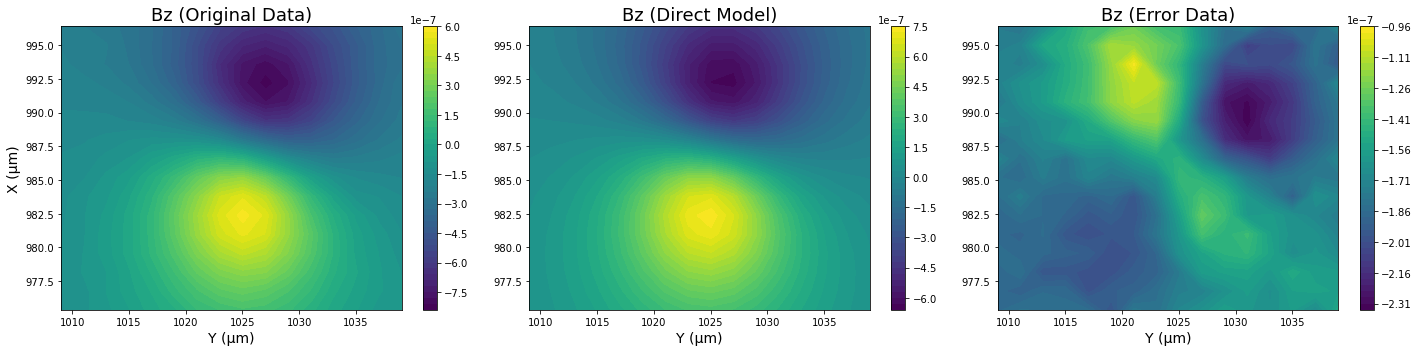

R2:  0.8968969452623432


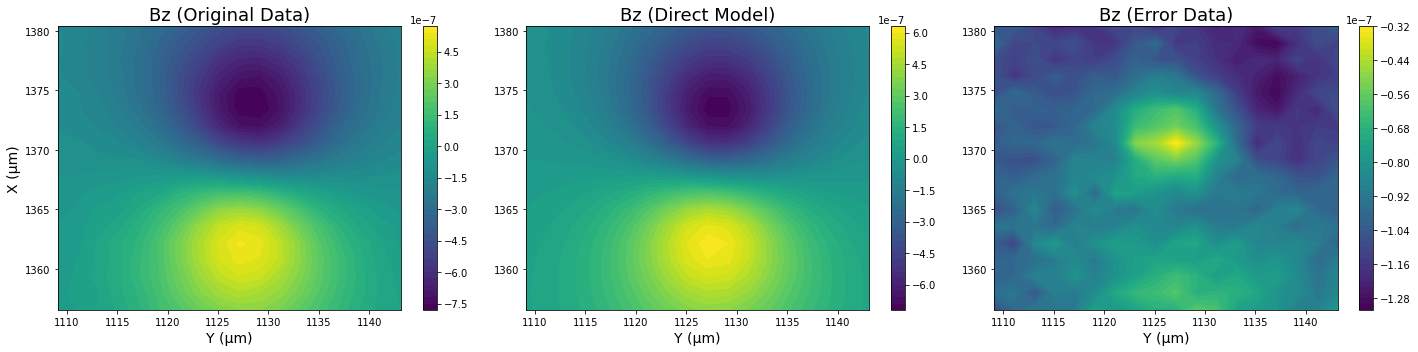

R2:  0.9820205158598027


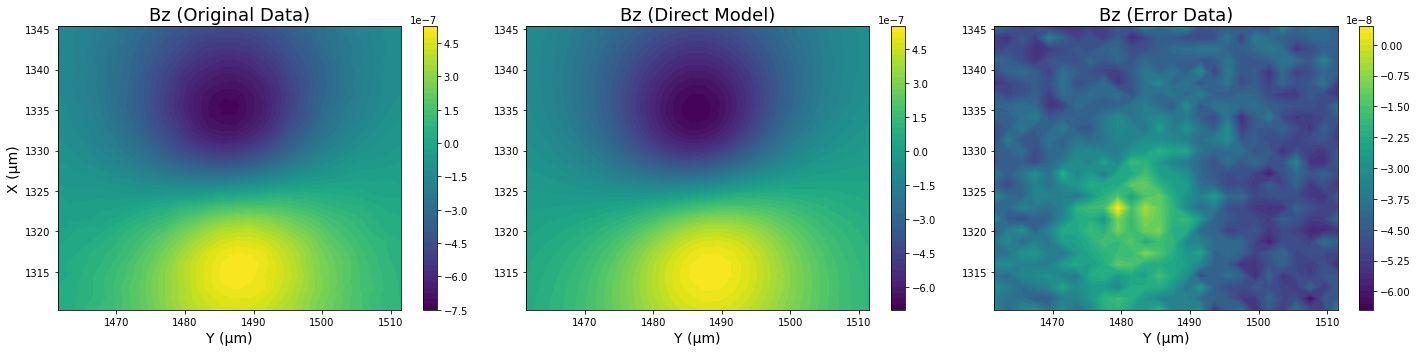

R2:  0.0895086616511448


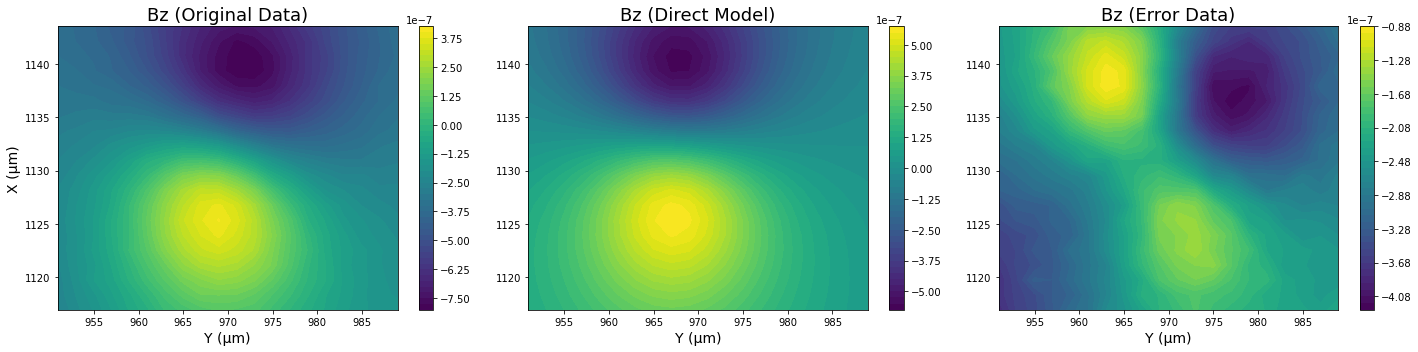

R2:  0.9952542278645715


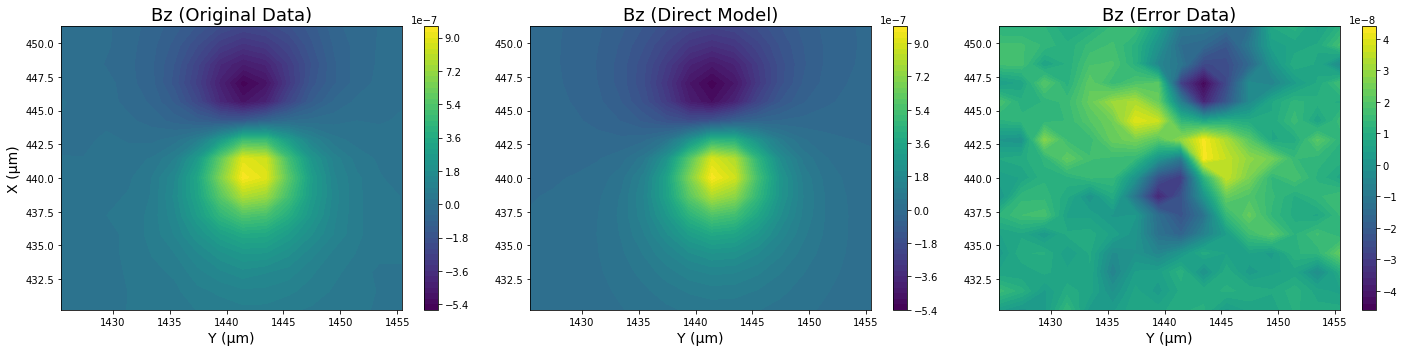

R2:  0.30344187595493566


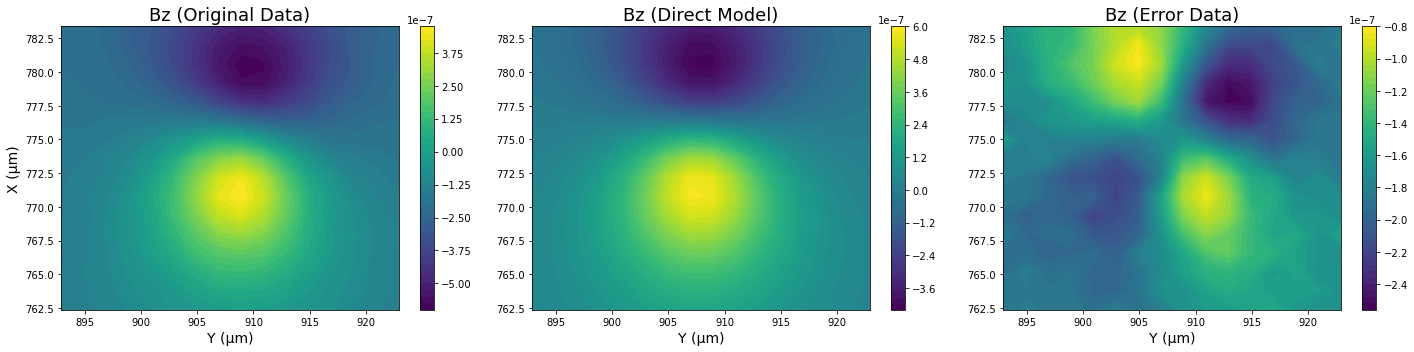

R2:  0.42008268310716024


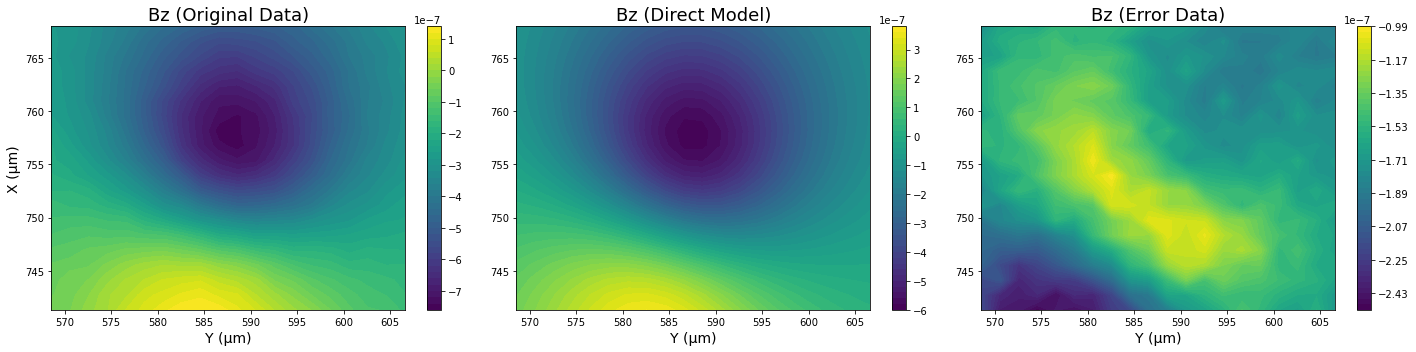

R2:  0.8631854939947962


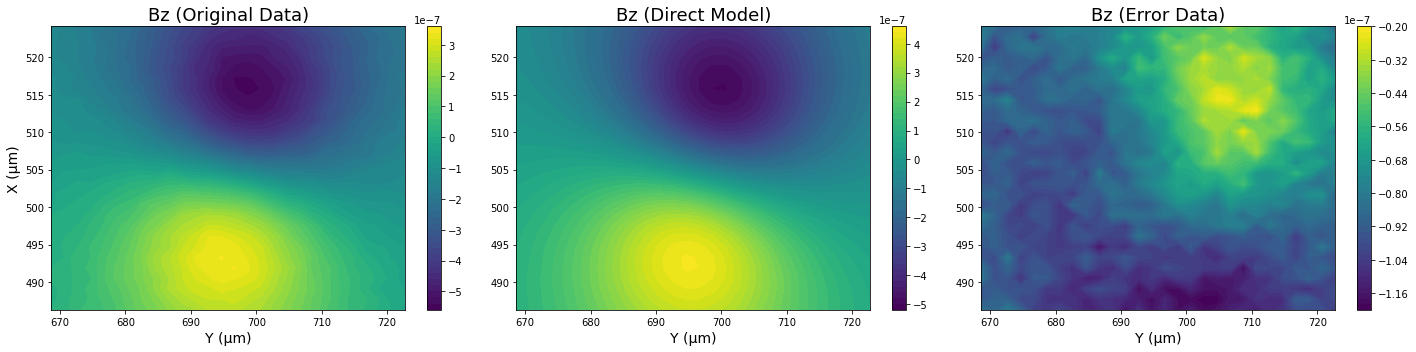

R2:  0.7959554361718288


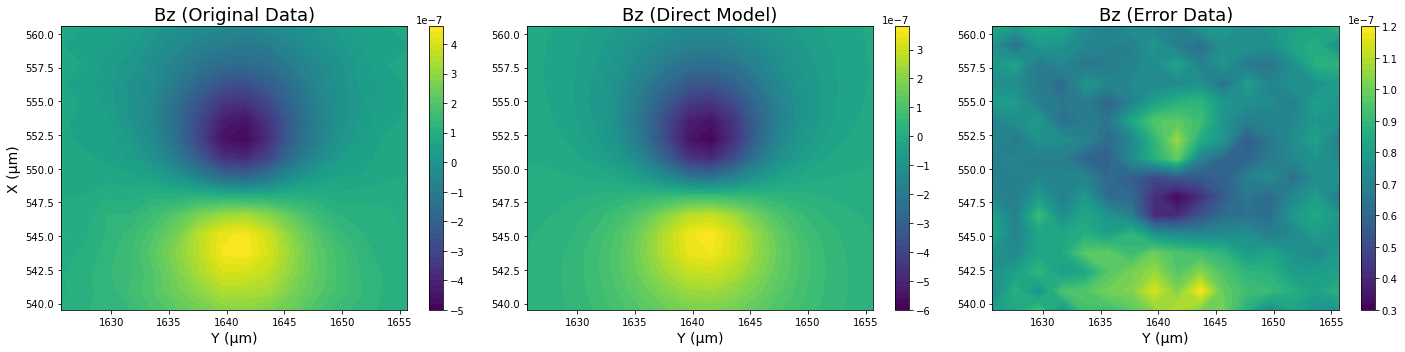

R2:  0.8166985985143549


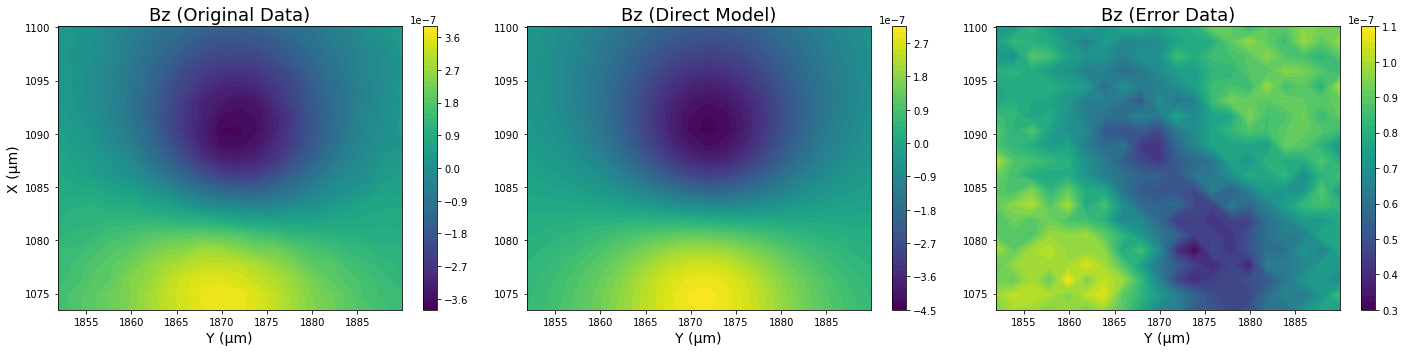

R2:  0.7828183195763644


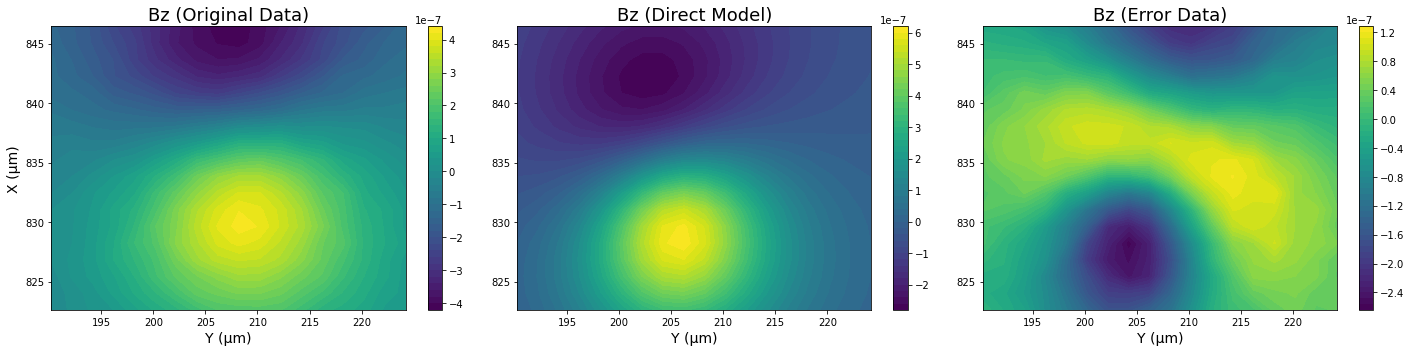

R2:  -0.6823253622033774


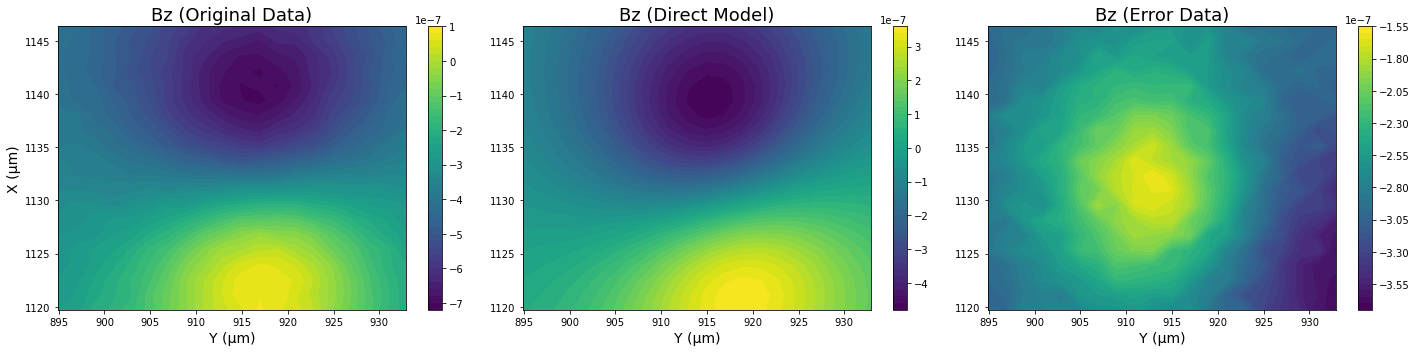

R2:  -1.2800075322411777


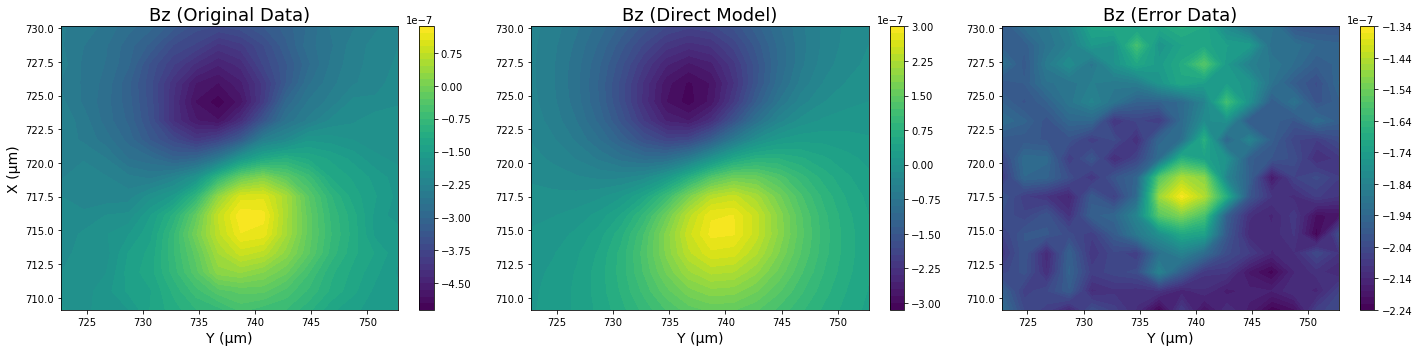

R2:  -3.59208532455915


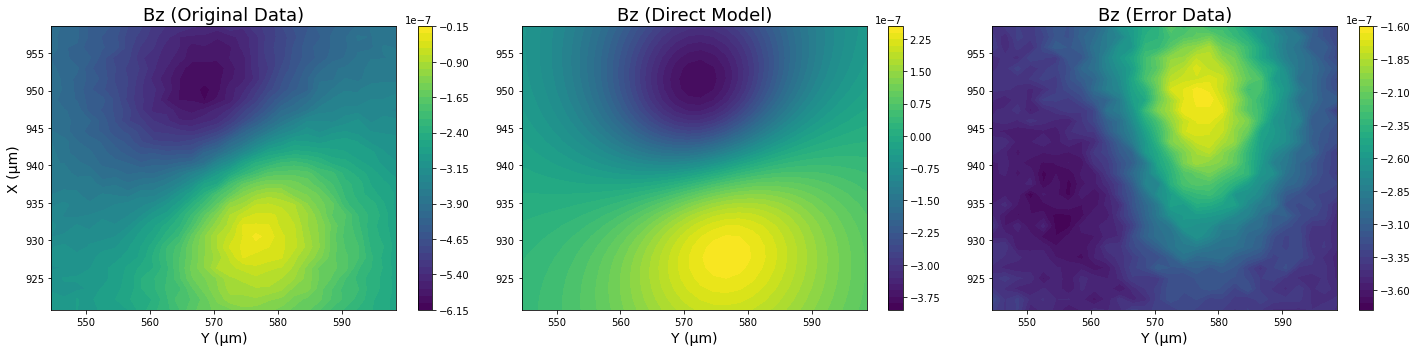

R2:  0.9956155125648781


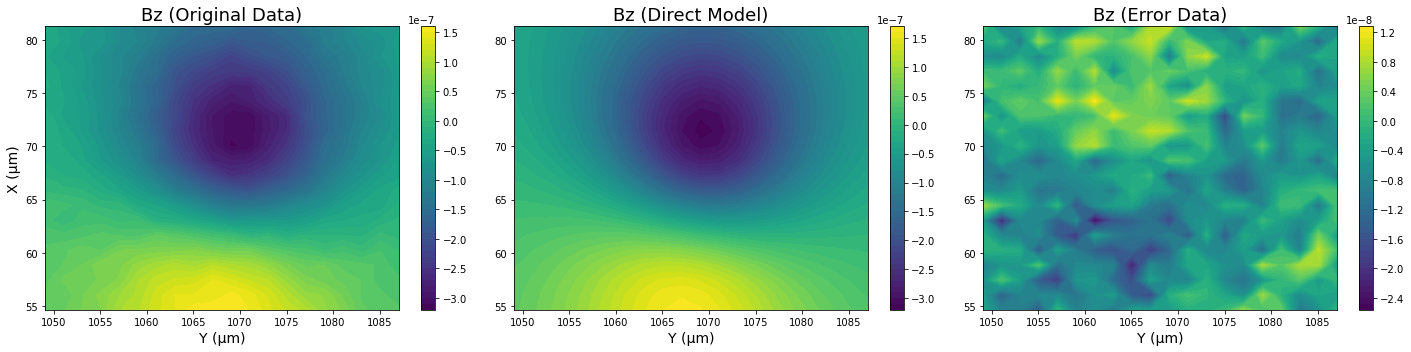

R2:  0.2917362667191544


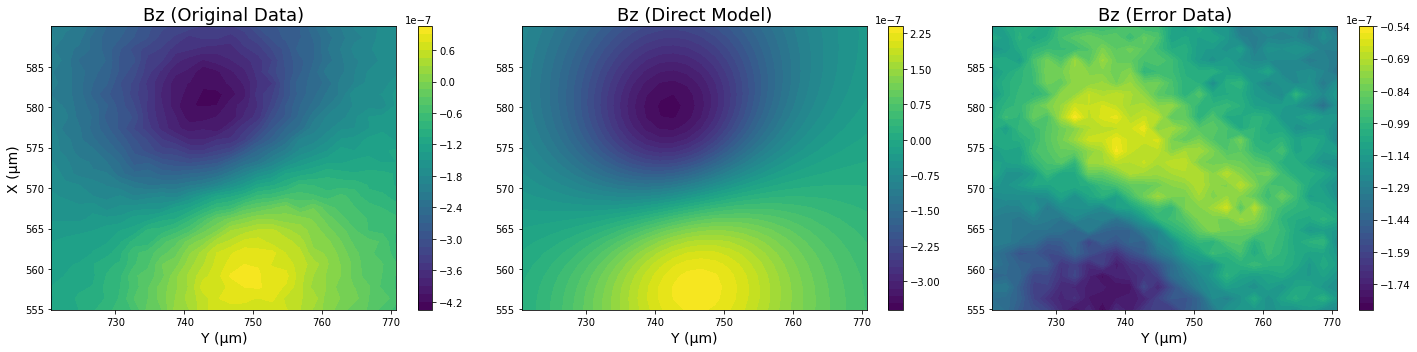

R2:  -4.99368512237805


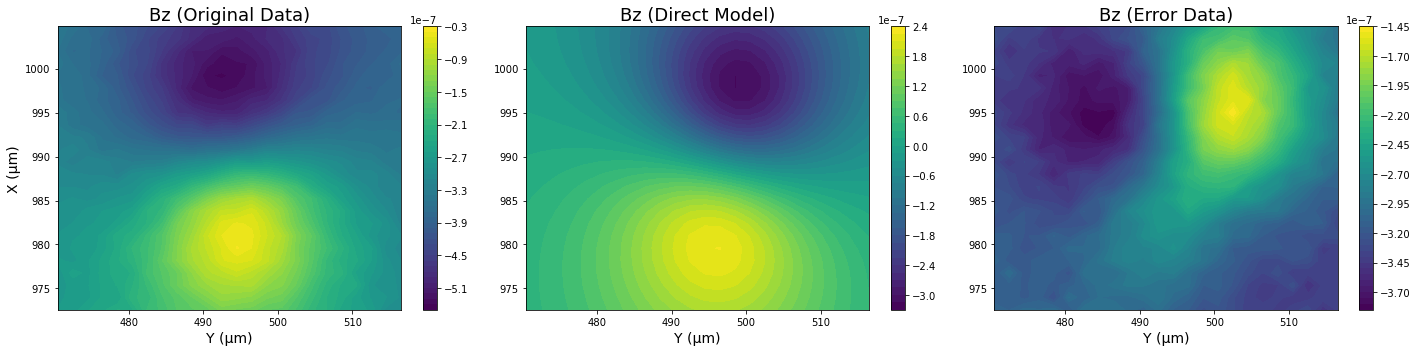

R2:  0.1385508268812874


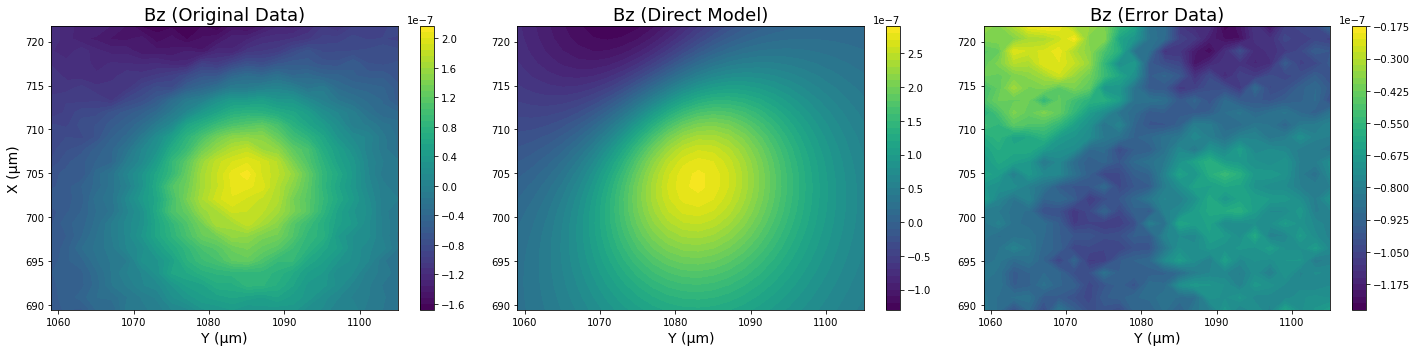

R2:  0.9887390897168233


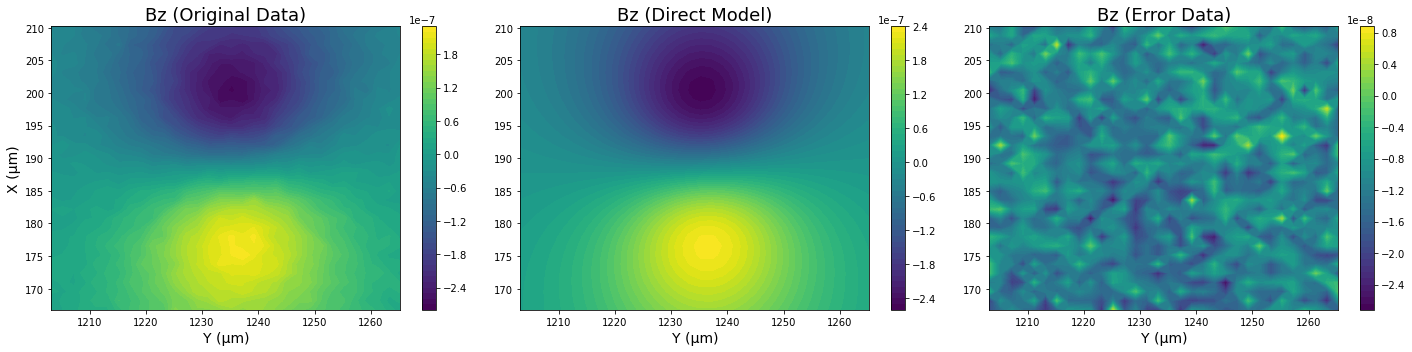

R2:  0.9956191099417723


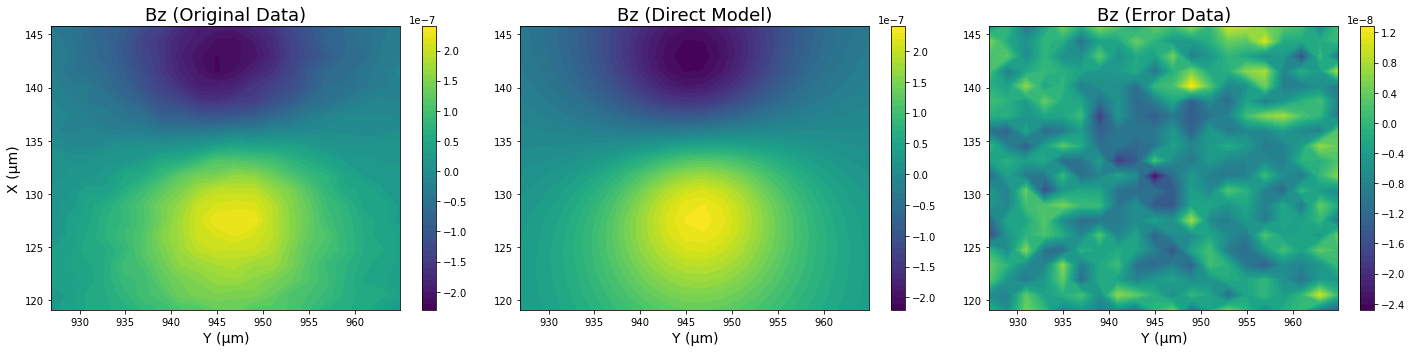

R2:  0.9871027497819039


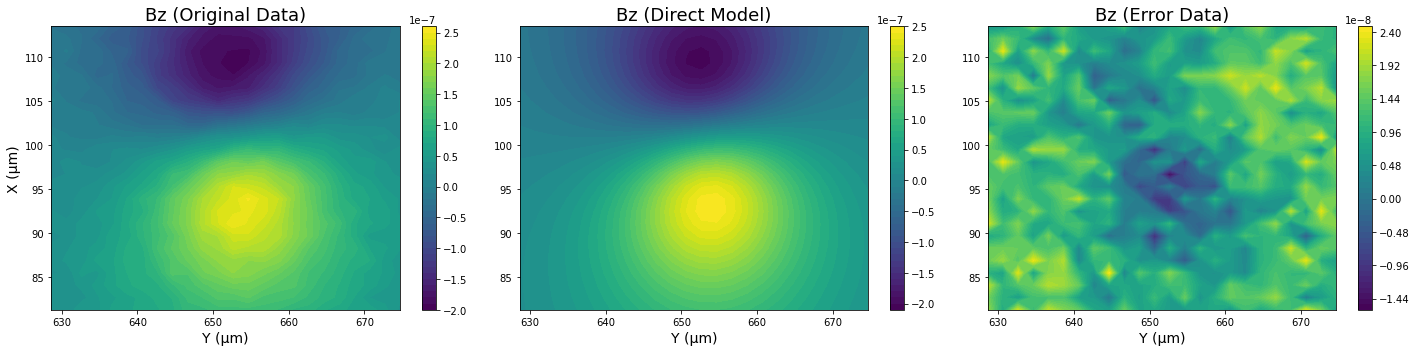

R2:  0.8883872641779212


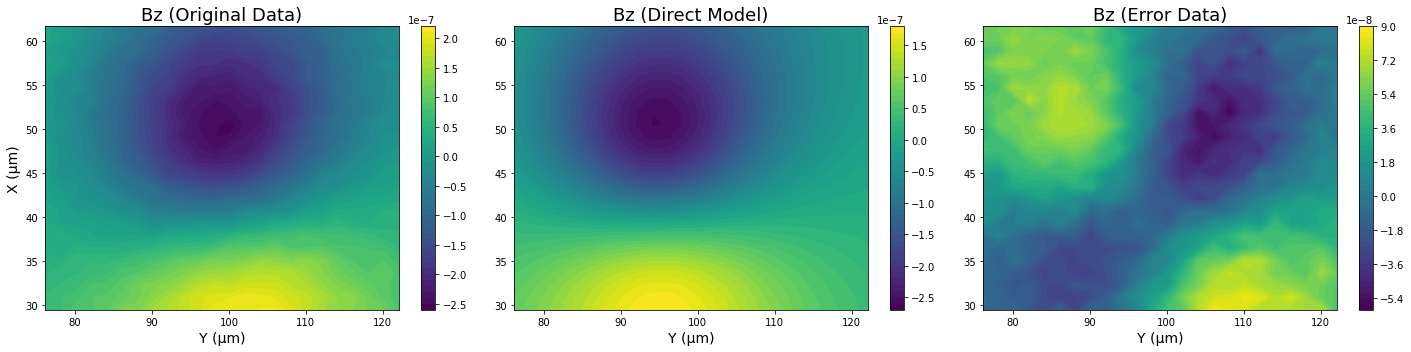

R2:  0.9298756763185205


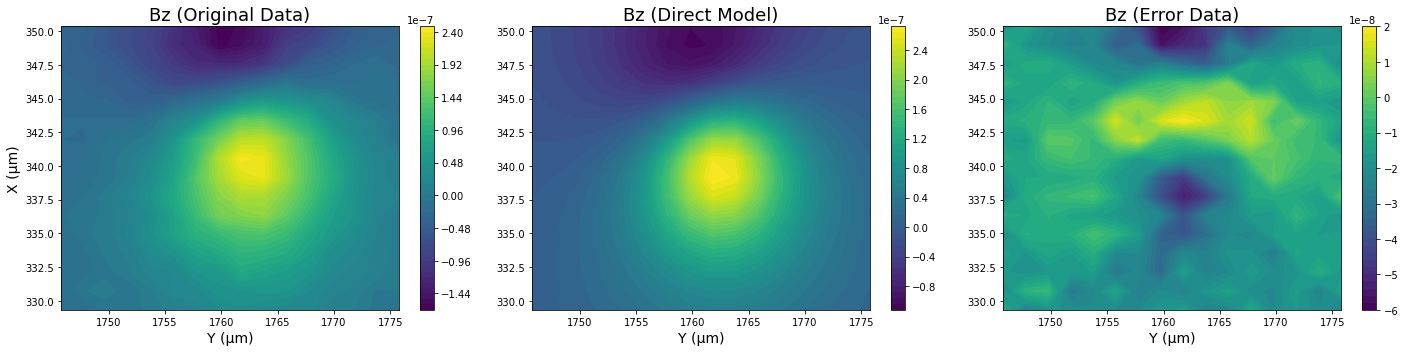

R2:  0.06925636134066171


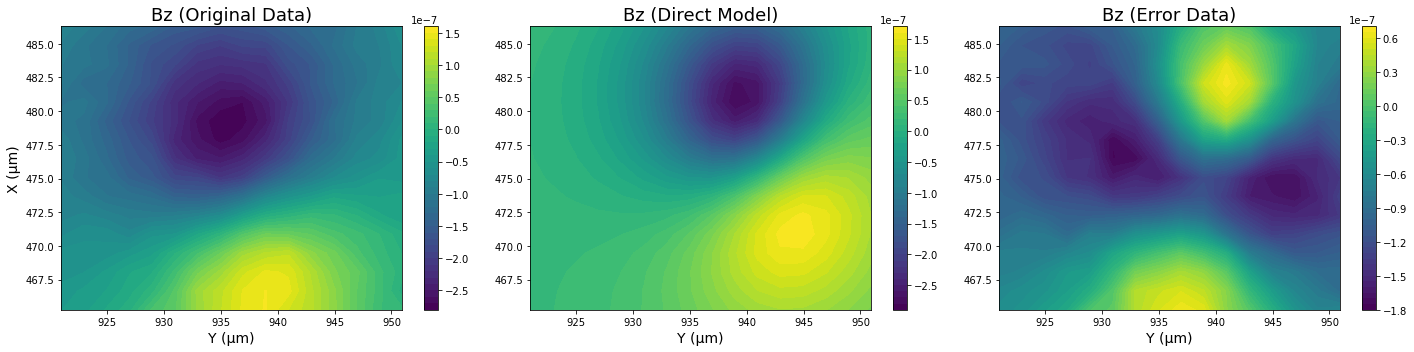

R2:  -16.41967040035429


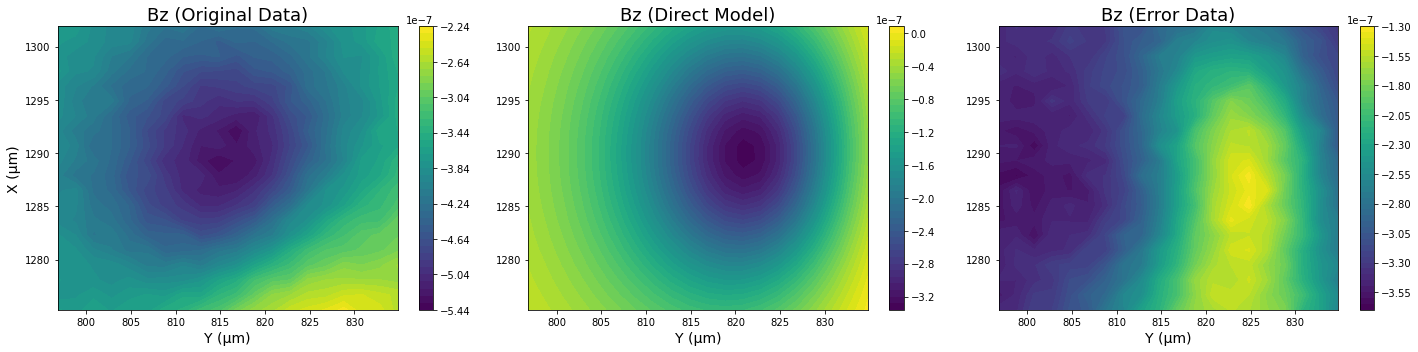

R2:  0.9048412234037035


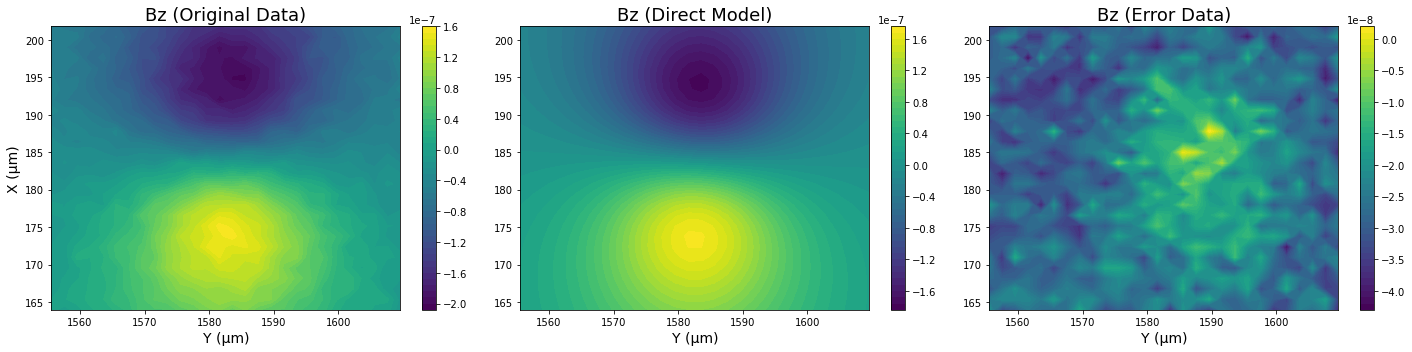

R2:  0.8787963897524317


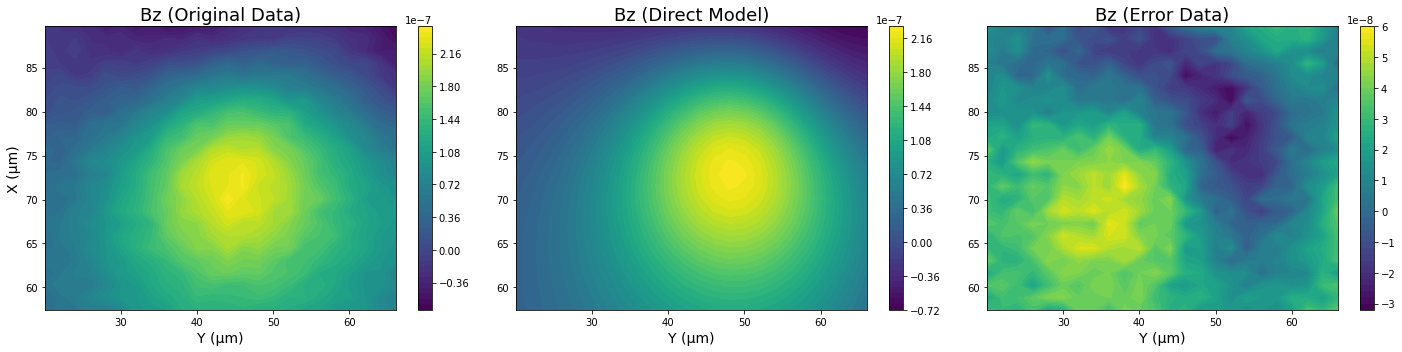

R2:  0.21960155949980154


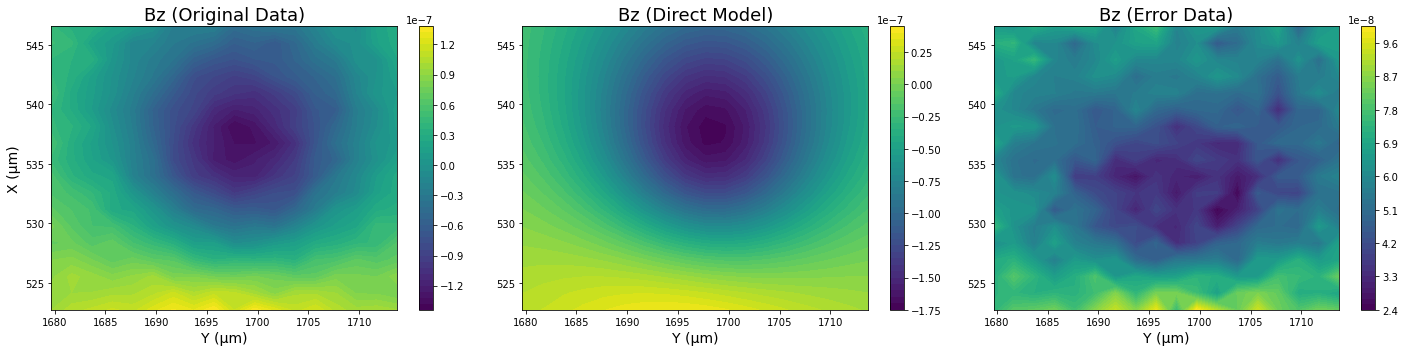

R2:  -4.1361886454074845


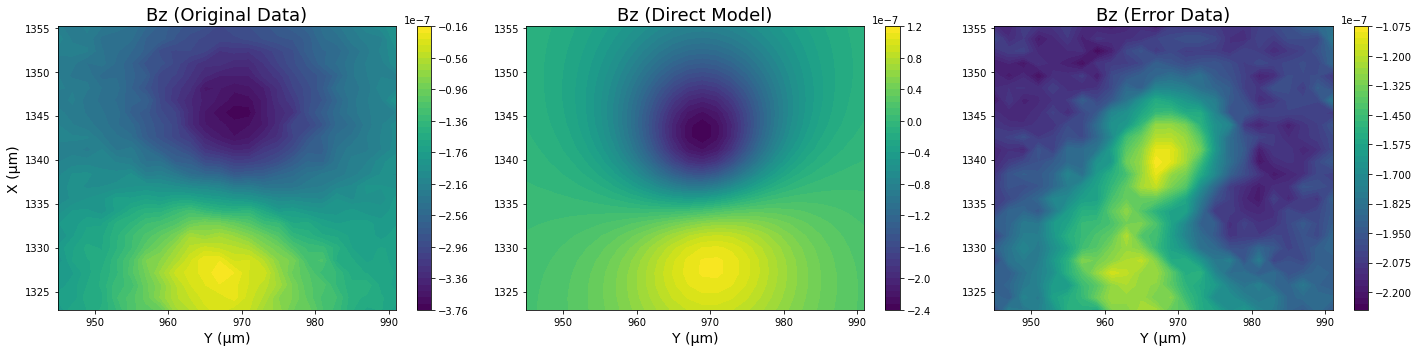

R2:  0.9347792313414235


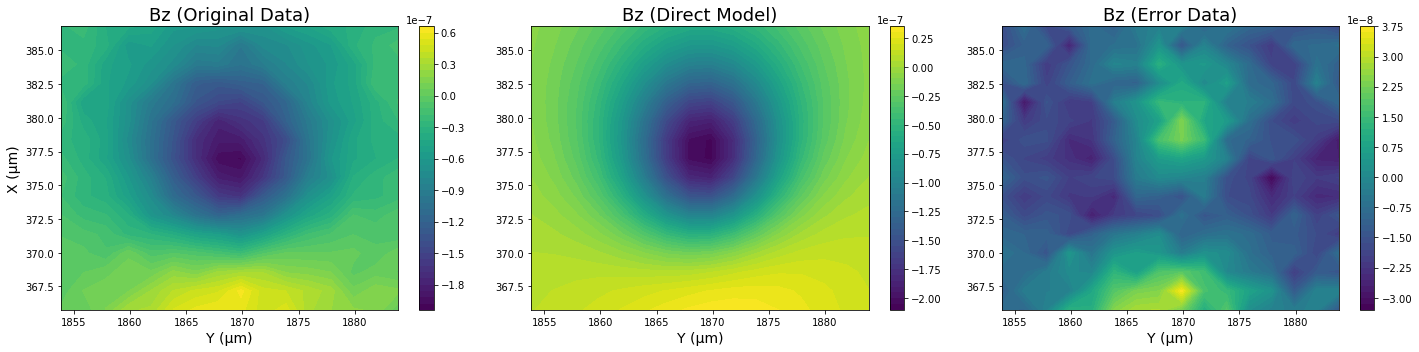

R2:  -1.9718990535010485


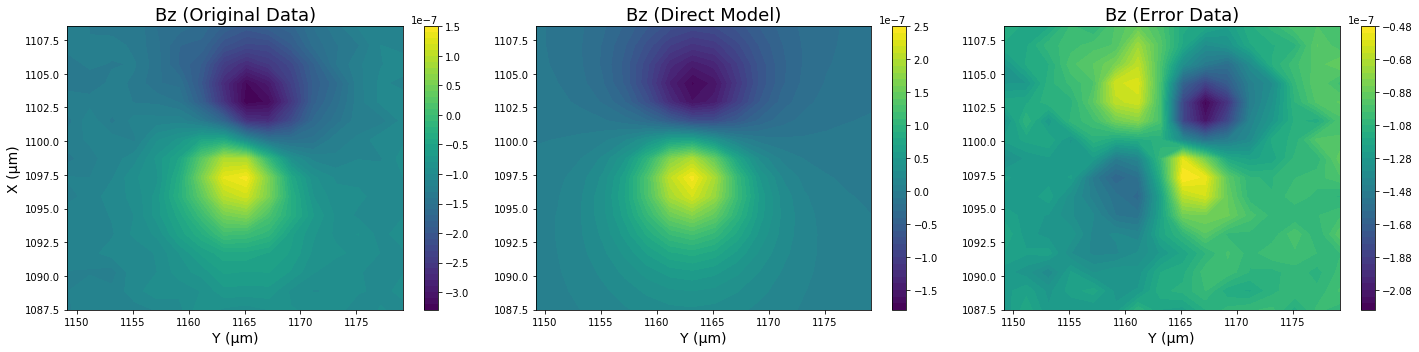

R2:  -0.23961463956466655


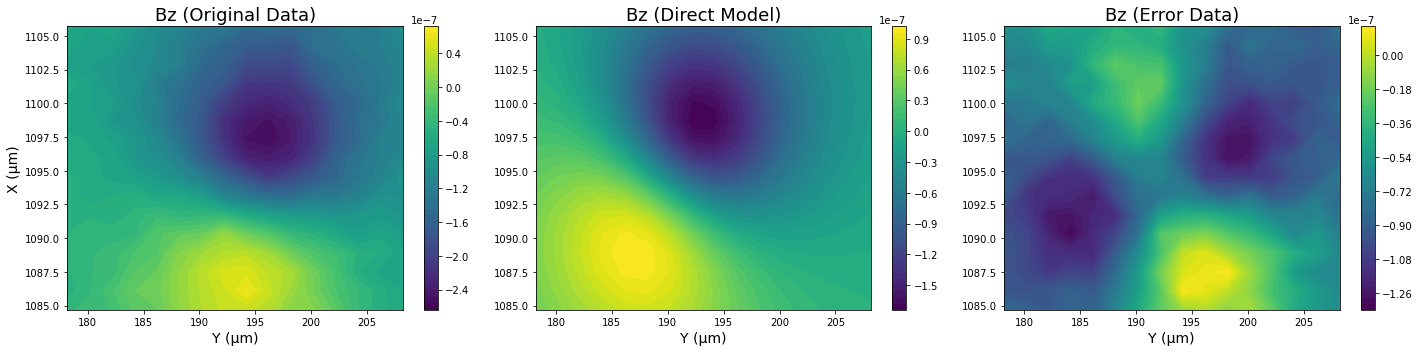

R2:  -20.60842883626096


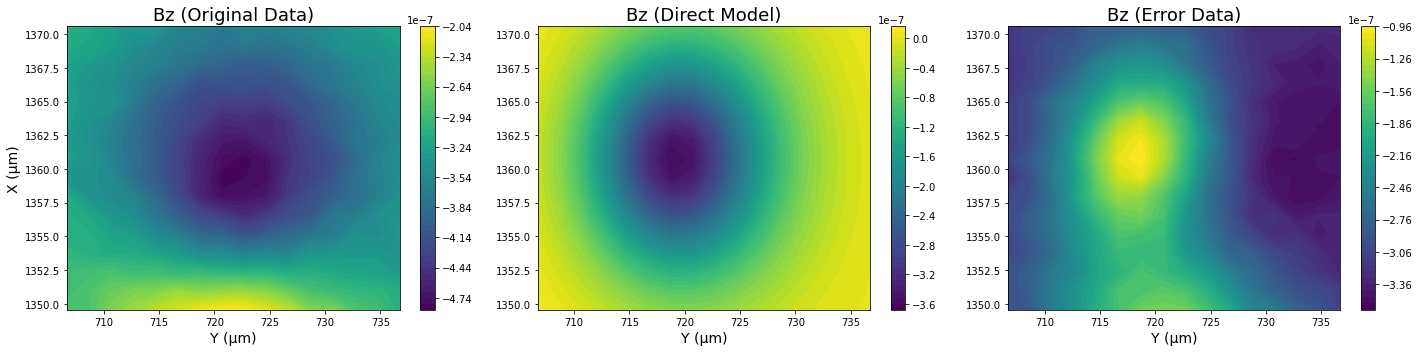

R2:  0.9173843609342699


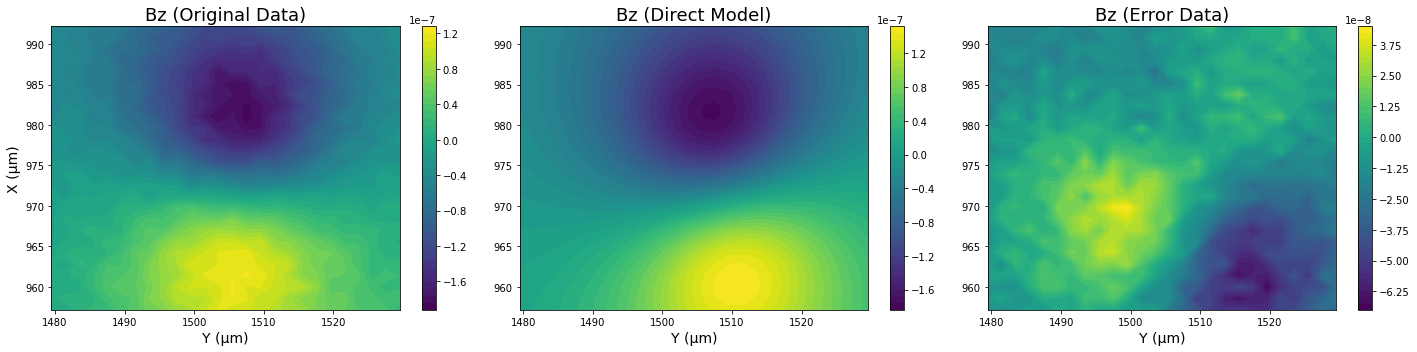

R2:  0.7642281124847375


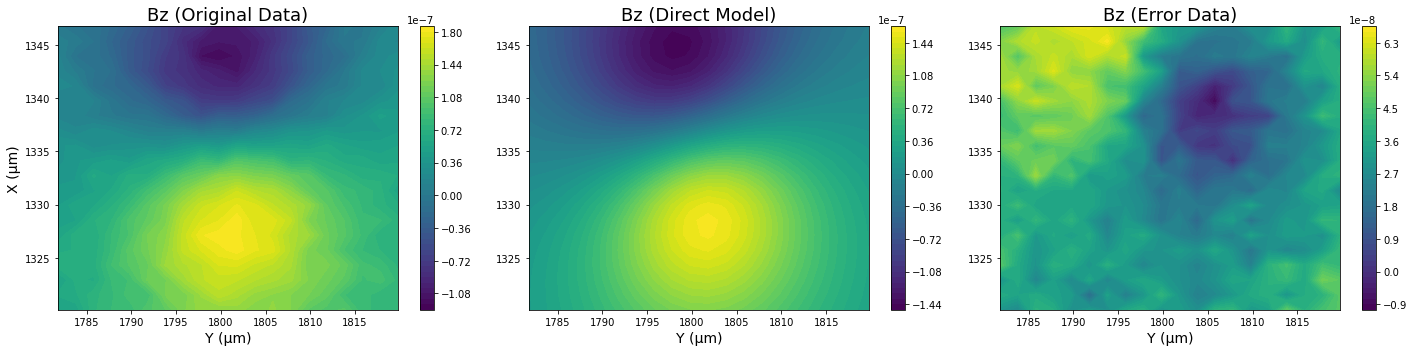

R2:  0.8468383281423839


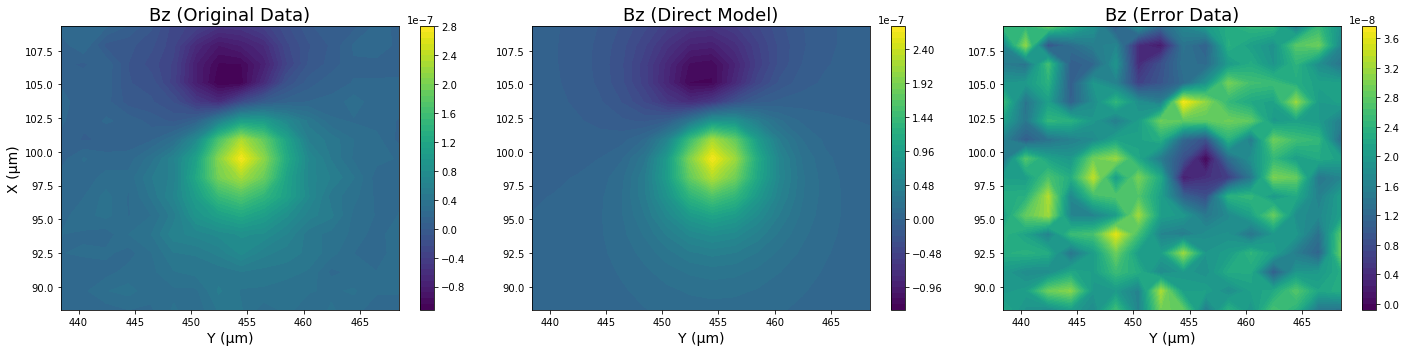

R2:  0.7554400000863765


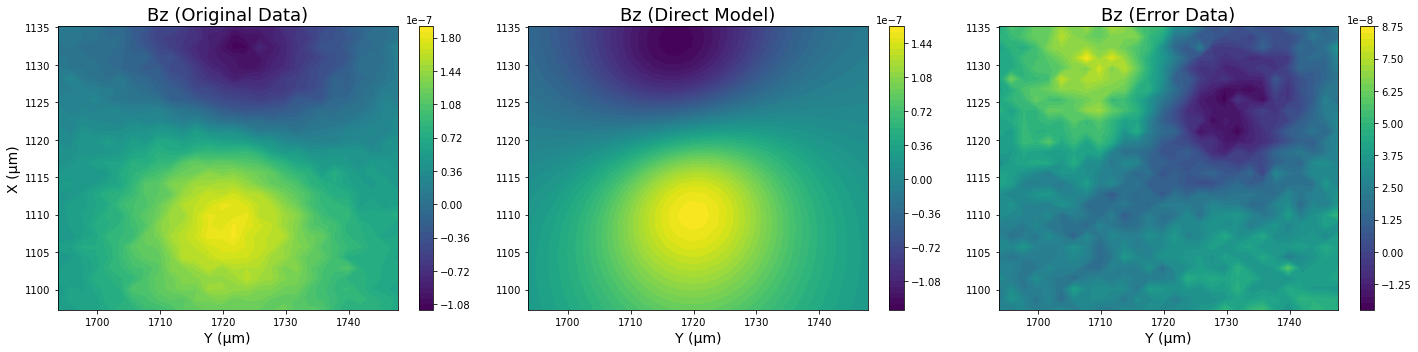

R2:  -13.98263987471407


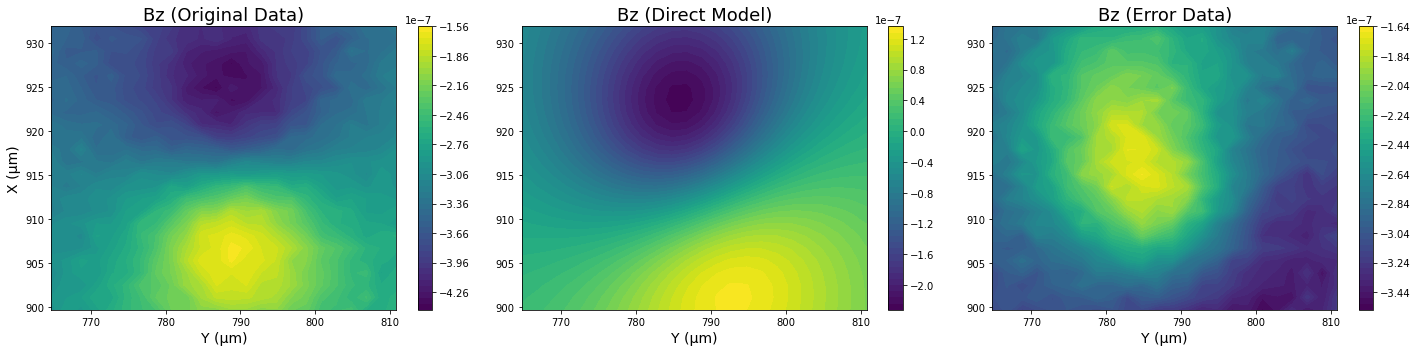

R2:  -10.890167486963168


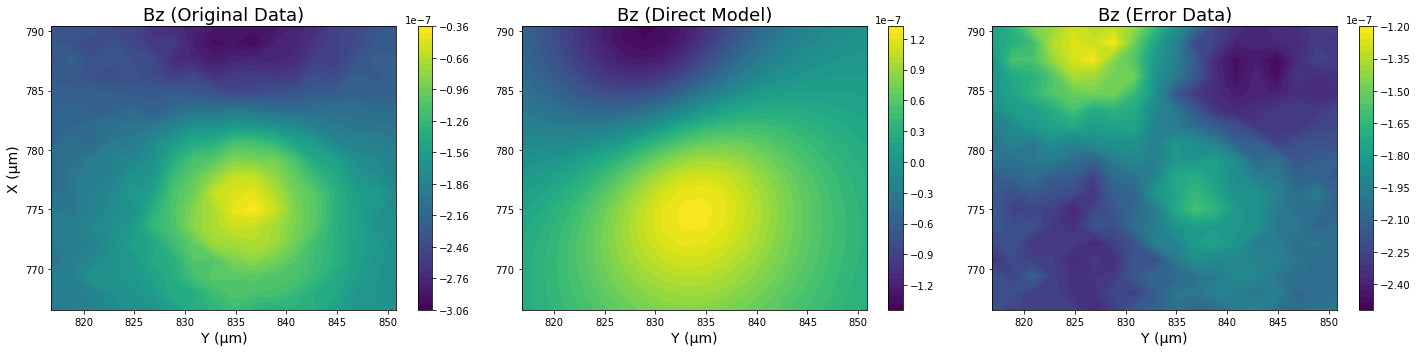

R2:  -2.285571718518296


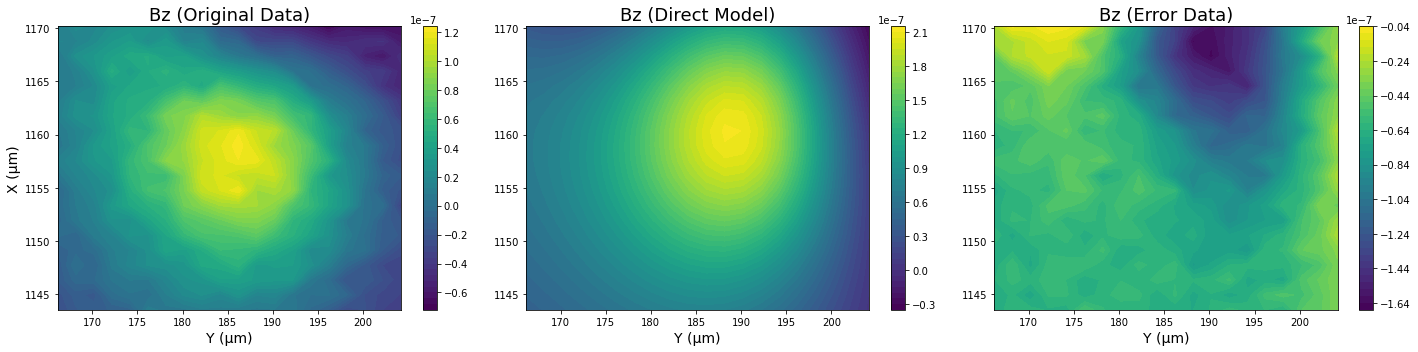

R2:  -28.325712198318982


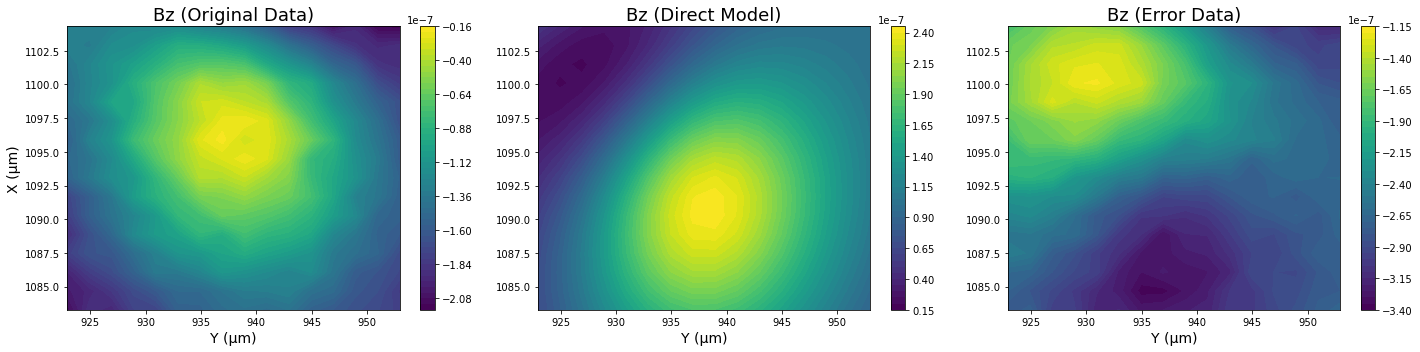

R2:  -0.9271949923213207


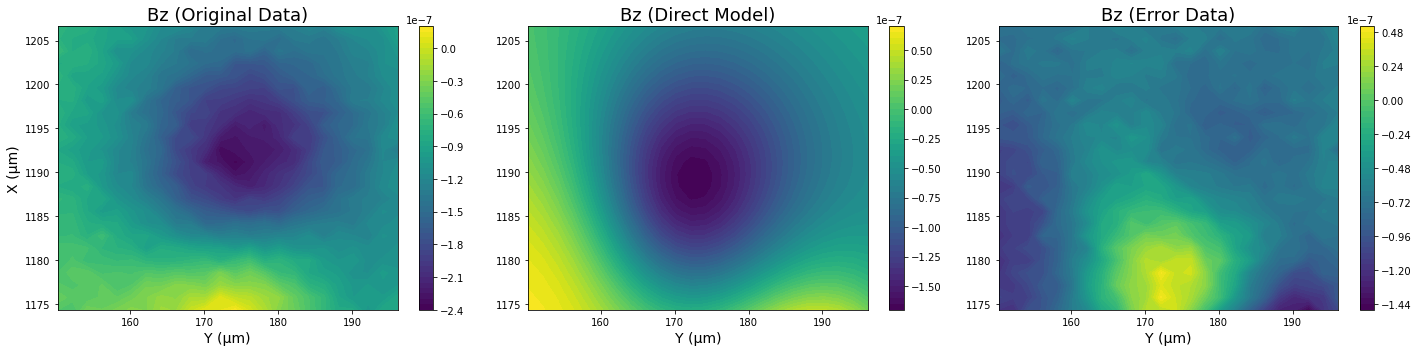

R2:  0.5954477648361063


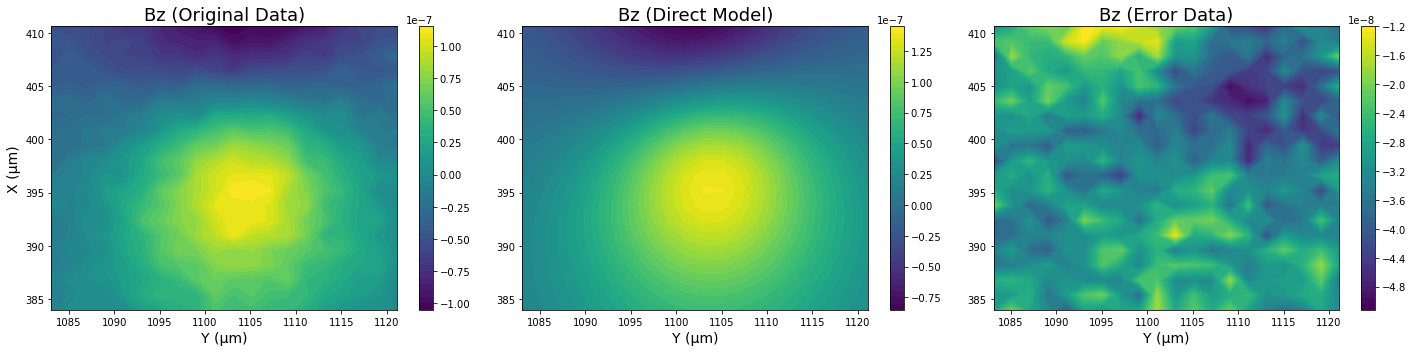

R2:  -2.8748283985696164


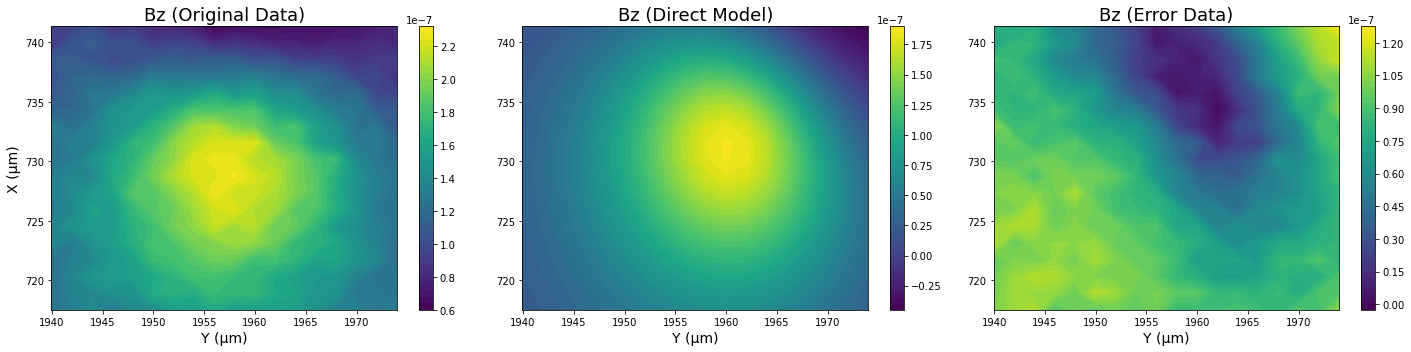

R2:  0.7075540775854559


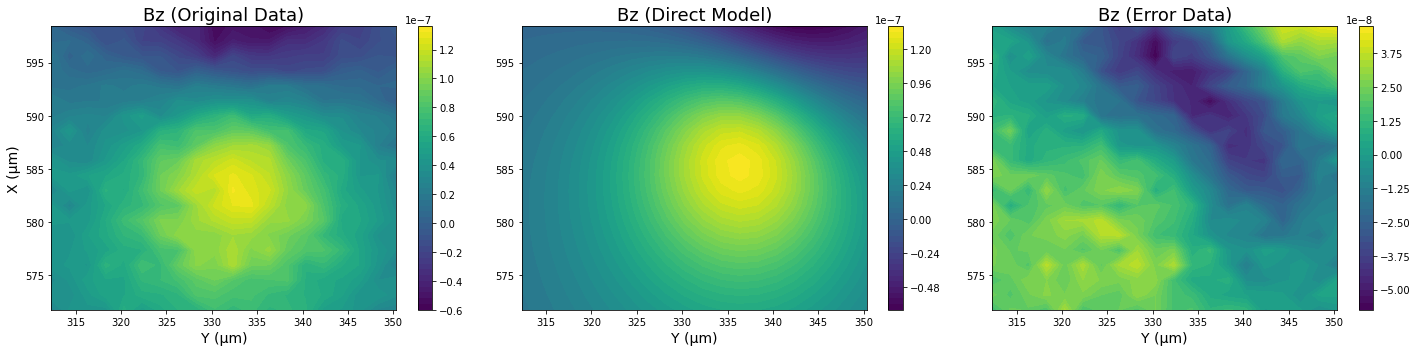

R2:  -89.26948246415051


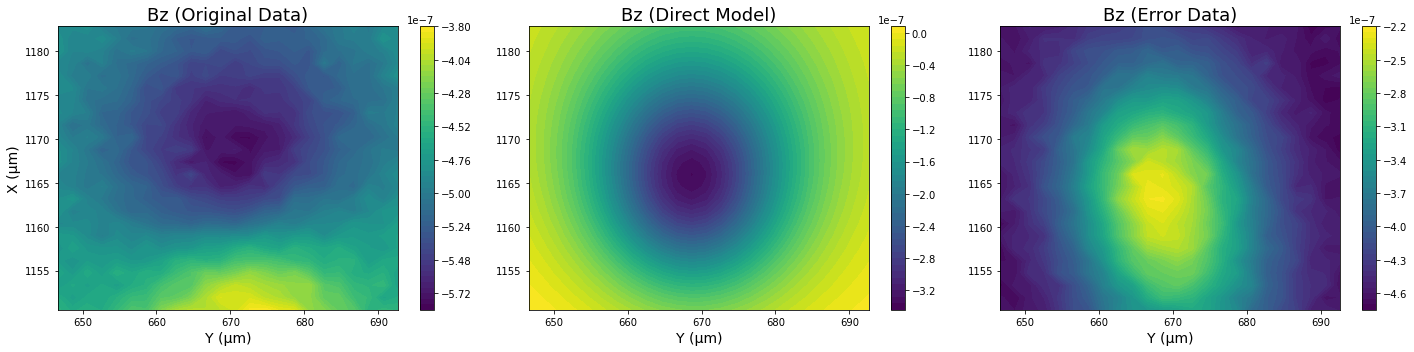

R2:  -0.06137789304974639


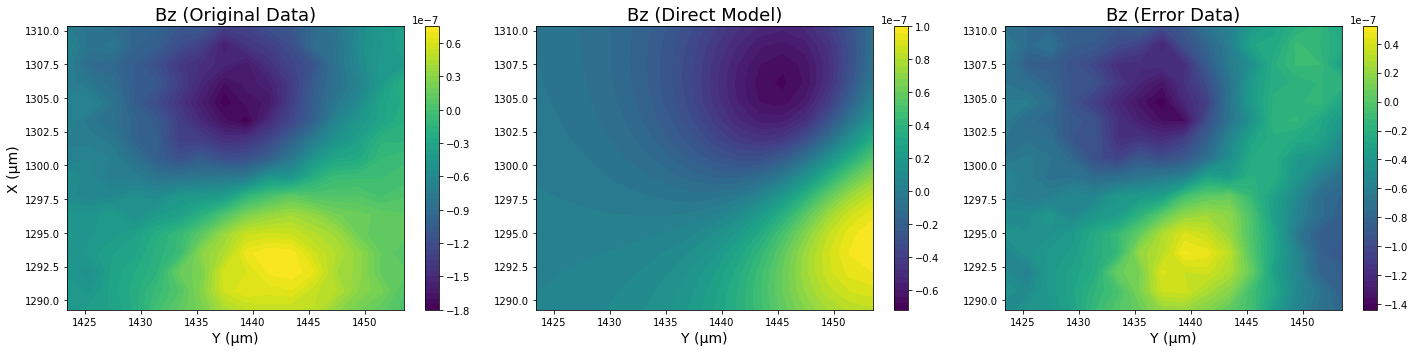

R2:  -30.638502169797704


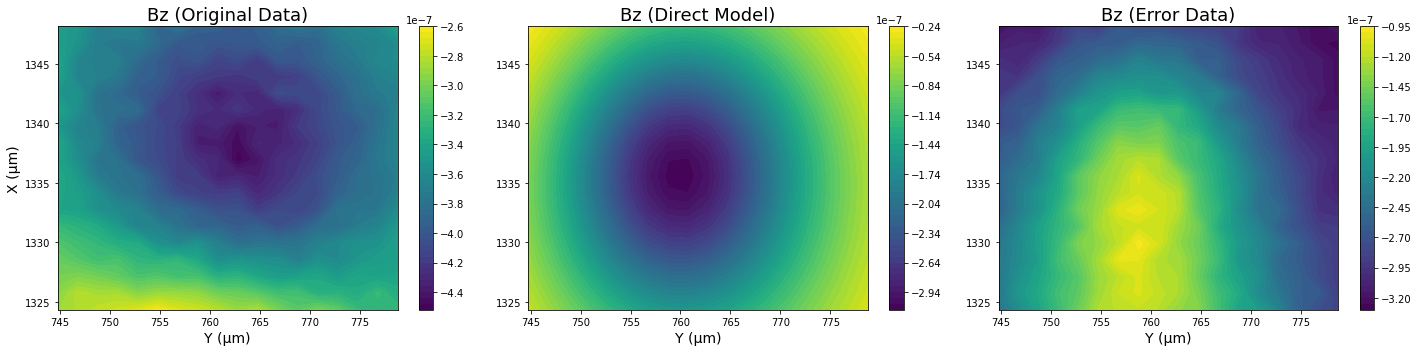

R2:  -0.3498315350439154


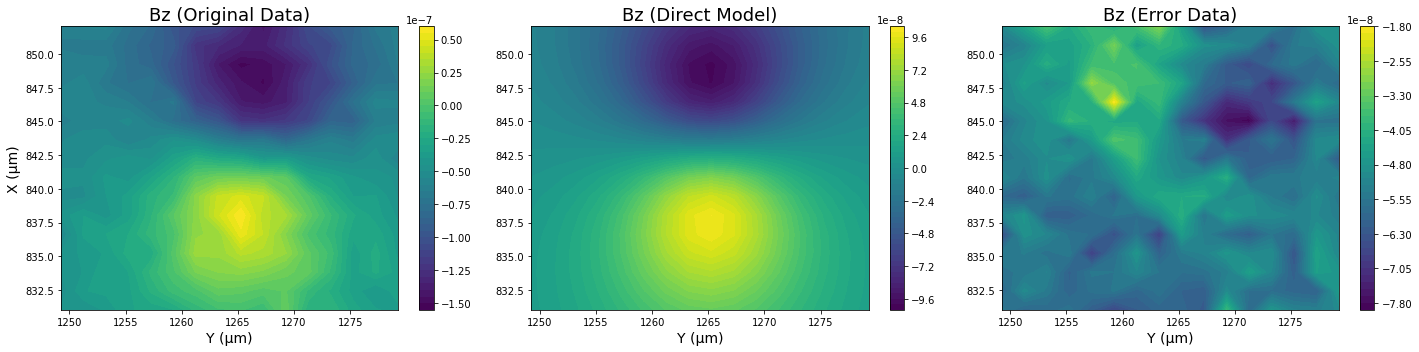

R2:  -0.7454716142715458


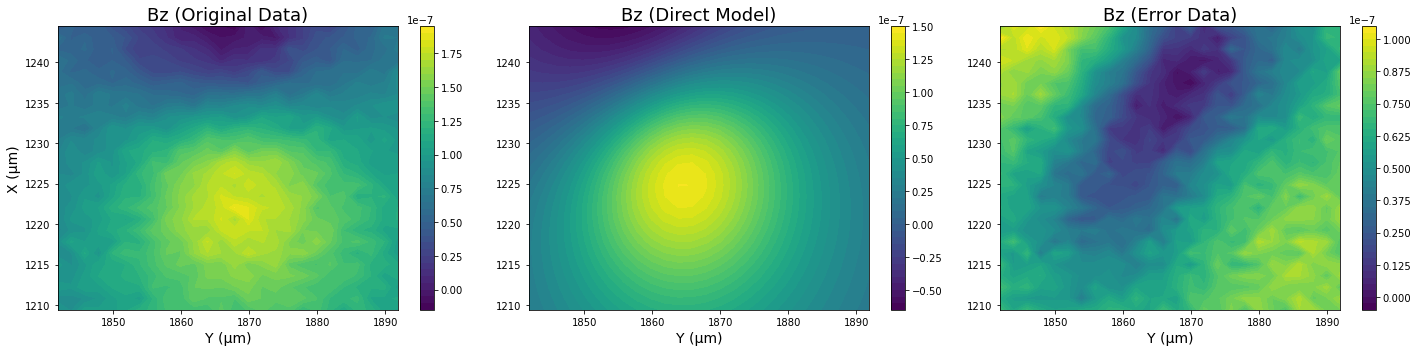

R2:  -39.331895766813545


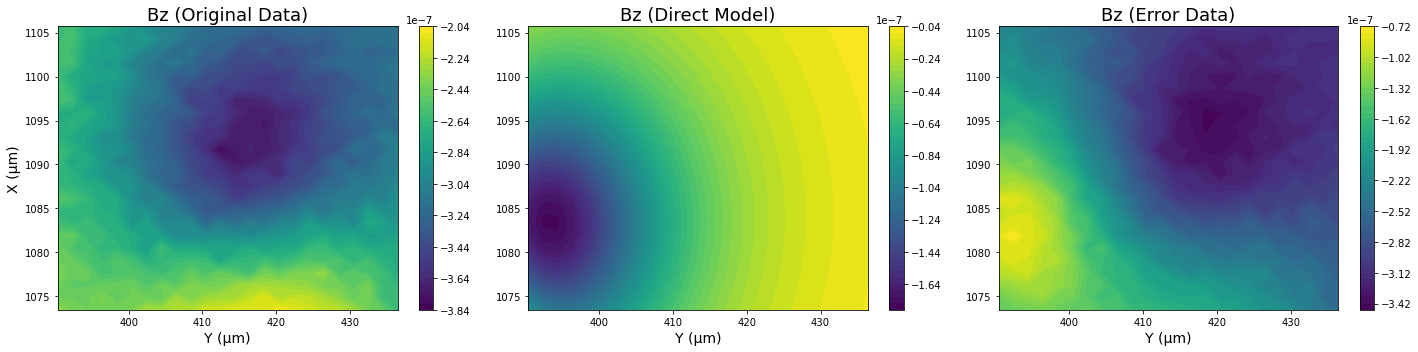

R2:  -0.6305483221069186


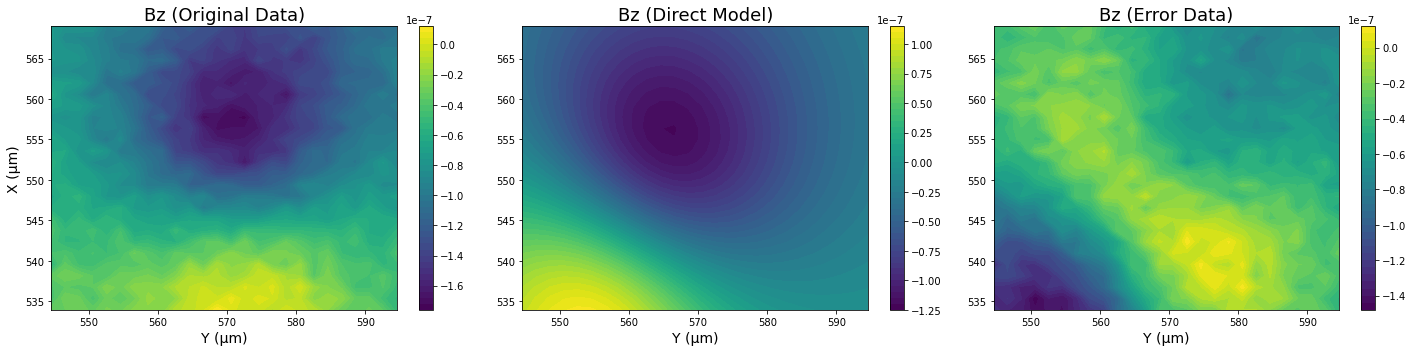

R2:  0.8029527288549018


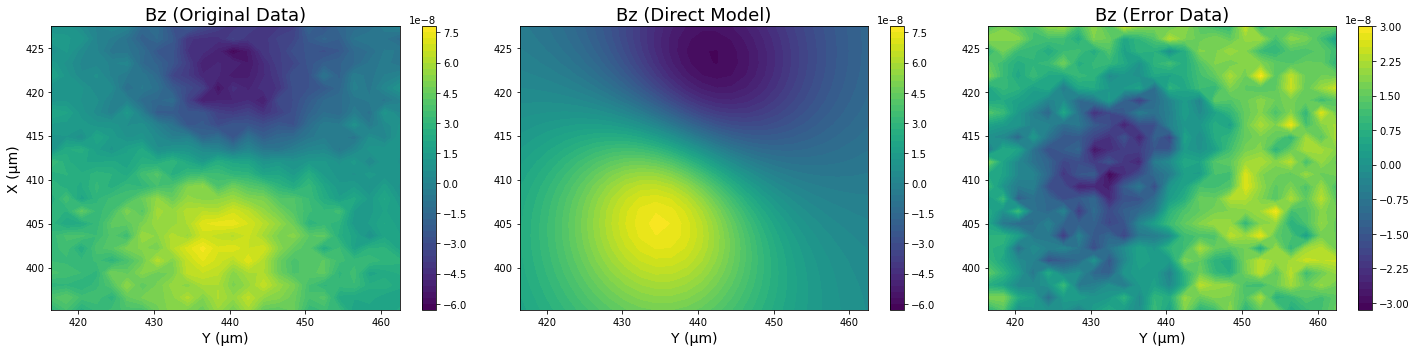

R2:  -6.9878191899789


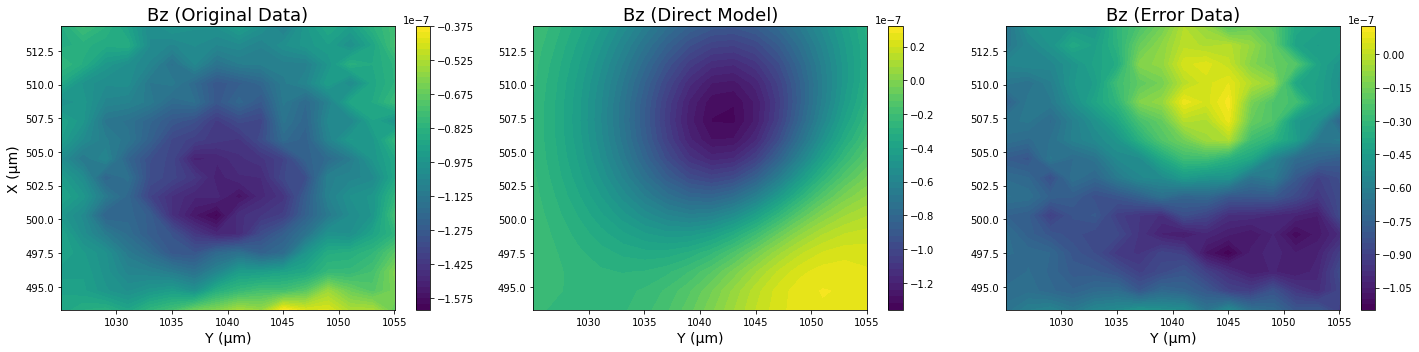

R2:  -0.6870895378510415


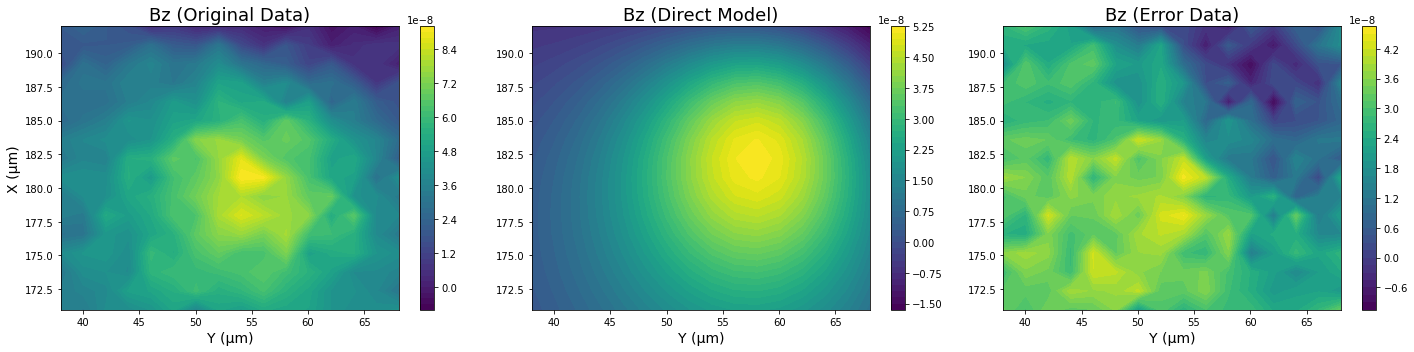

R2:  -36.73763871525419


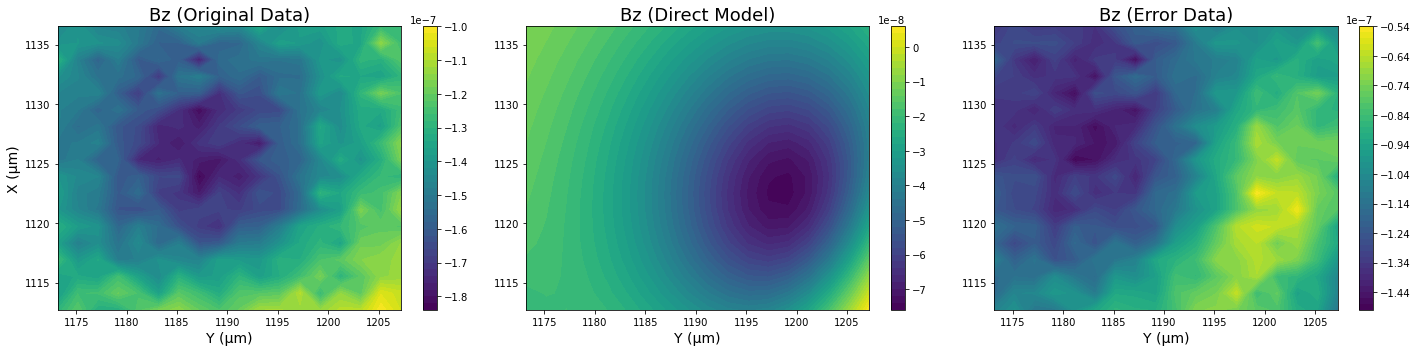

R2:  -0.9578611093194462


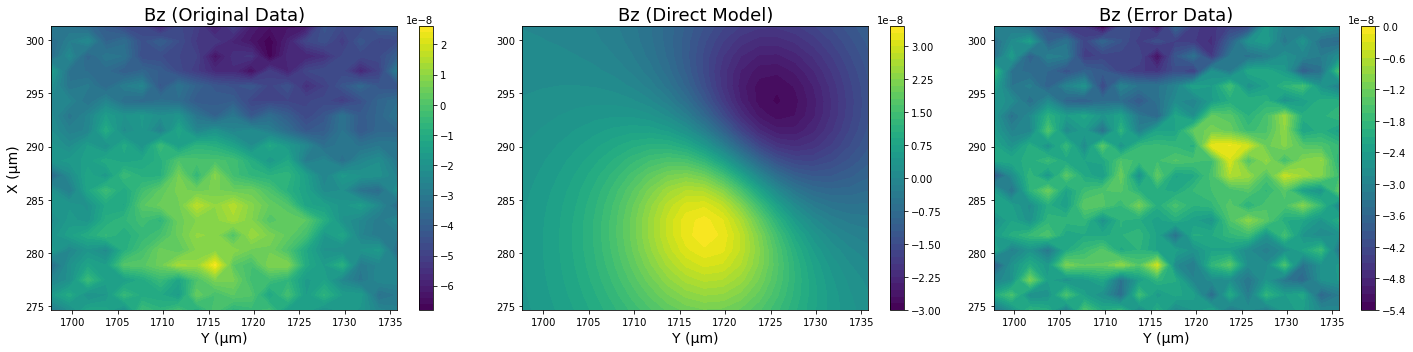

R2:  0.3319817378074874


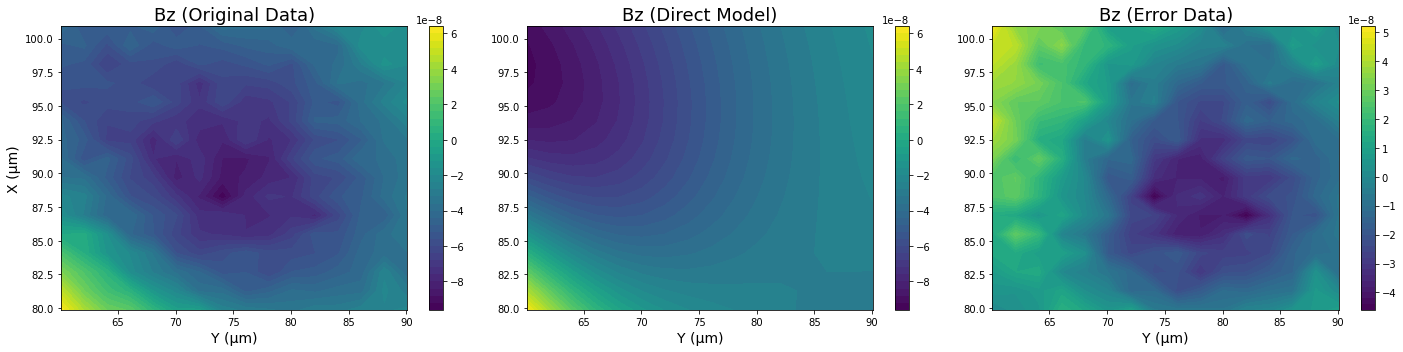

R2:  -70.76022281768341


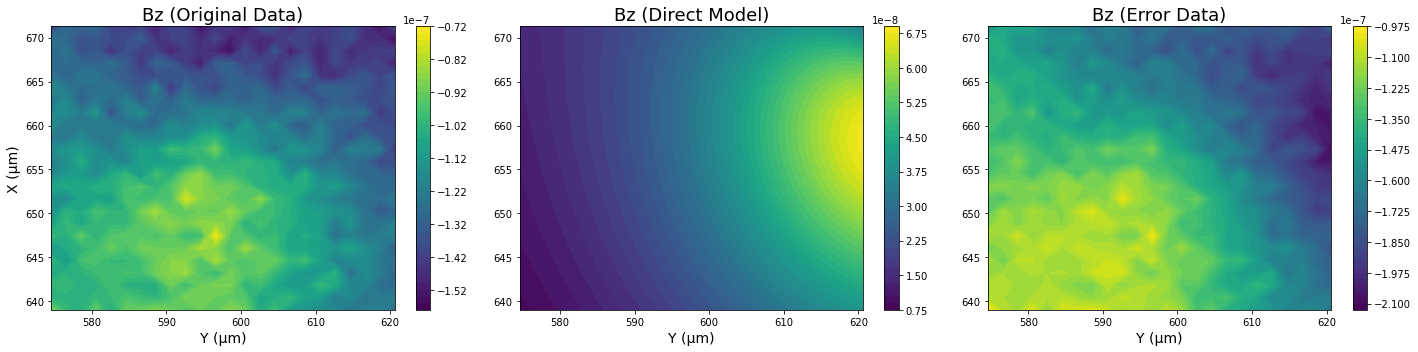

R2:  0.09799774609017309


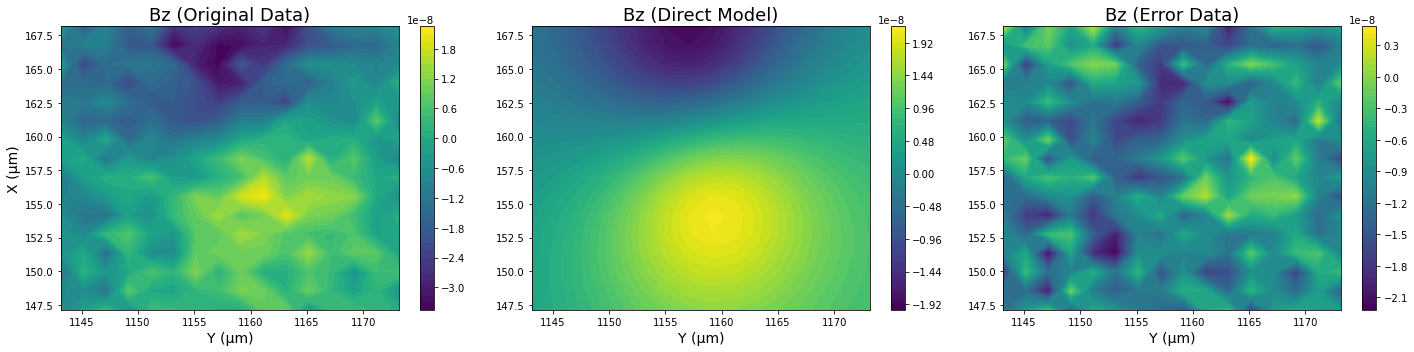

In [39]:
Xc_save, Yc_save, Zc_save = [], [], []
mx_save, my_save, mz_save = [], [], []
m_save, D_save, I_save = [], [], []
sigma_m_save, sigma_D_save, sigma_I_save = [], [], []
deter_coef_save = []

show=True


for i in range(np.shape(filtered_euler_windows_FD)[0]):
    
    if Zc_FD[i]>=0:
        x1, x2 = int(euler_windows_FD[i,0]), int(euler_windows_FD[i,1])
        y1, y2 = int(euler_windows_FD[i,2]), int(euler_windows_FD[i,3])

        data_normalized = original_data[x1:x2, y1:y2] #/(np.absolute(np.max(original_data[x1:x2, y1:y2])
                                                       #  -np.min(original_data[x1:x2, y1:y2])))

        model_normalized = upward_direct_model_FD_least[x1:x2, y1:y2] #/
                            #(np.absolute(np.max(upward_direct_model_FD_least[x1:x2, y1:y2])
                            #-np.min(upward_direct_model_FD_least[x1:x2, y1:y2]))) )

        error_normalized = data_normalized-model_normalized

        SQ_tot = np.sum( (data_normalized-np.mean(data_normalized))**2 )
        SQ_res = np.sum( (data_normalized-model_normalized)**2 )
        deter_coef = 1 - (SQ_res/SQ_tot)
        

        momentum = (np.sqrt(mx_FD_least[i]**2 + my_FD_least[i]**2 + mz_FD_least[i]**2))
        Xc_save.append(Xc_FD[i]*m2microm)
        Yc_save.append(Yc_FD[i]*m2microm)
        Zc_save.append(Zc_FD[i]*m2microm)
        mx_save.append(mx_FD_least[i])
        my_save.append(my_FD_least[i])
        mz_save.append(mz_FD_least[i])
        m_save.append(momentum)
        sigma_m_save.append(sigma_m_FD_least[i])
        D_save.append(D_FD_least[i])
        sigma_D_save.append(sigma_D_FD_least[i])
        I_save.append(I_FD_least[i])
        sigma_I_save.append(sigma_I_FD_least[i])
        deter_coef_save.append(deter_coef)

        if show:
            print('R2: ', deter_coef)

            fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

            ax1_plot = ax1.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], 
                                    original_data[x1:x2, y1:y2], levels=50, cmap='viridis')
            plt.colorbar(ax1_plot, ax=ax1)
            ax1.set_title('Bz (Original Data)', fontsize=18)
            ax1.set_xlabel('Y (µm)', fontsize=14)
            ax1.set_ylabel('X (µm)', fontsize=14)


            ax2_plot = ax2.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], 
                                    upward_direct_model_FD_least[x1:x2, y1:y2], levels=50, cmap='viridis')
            plt.colorbar(ax2_plot, ax=ax2)
            ax2.set_title('Bz (Direct Model)', fontsize=18)
            ax2.set_xlabel('Y (µm)', fontsize=14)

            error = original_data[x1:x2, y1:y2] - upward_direct_model_FD_least[x1:x2, y1:y2]
            ax3_plot = ax3.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], error, levels=50, cmap='viridis')
            plt.colorbar(ax3_plot, ax=ax3)
            ax3.set_title('Bz (Error Data)', fontsize=18)
            ax3.set_xlabel('Y (µm)', fontsize=14)

            plt.tight_layout()
            plt.show()

                    
df_final = pd.DataFrame(data={'Xc (µm)': np.array(np.round(Xc_save, decimals=4)),
                              'Yc (µm)': np.array(np.round(Yc_save, decimals=4)),
                              'Zc (µm)': np.array(np.round(Zc_save, decimals=4)),
                              'mx (Am2)': np.array(mx_save),
                              'my (Am2)': np.array(my_save),
                              'mz (Am2)': np.array(mz_save),
                              'm (Am2)': np.array(m_save),
                              'sigma m (Am2)': np.array(sigma_m_save),
                              'D (°)': np.array(D_save),
                              'sigma D (°)': np.array(sigma_D_save),
                              'I (°)': np.array(I_save),
                              'sigma I (°)': np.array(sigma_I_save),
                              'R2': np.array(deter_coef_save)

                       })

In [40]:
df_final.head(-5)
display(df_final)

Xc (µm)    Yc (µm)  Zc (µm)      mx (Am2)      my (Am2)      mz (Am2)  \
0    549.9940   937.9974   3.1187  1.858116e-13 -5.711489e-14 -3.651688e-14   
1    980.0200  1624.9642   1.1715  1.700220e-14  1.834241e-15  2.016929e-15   
2    401.0011  1206.0178   9.1044  9.606862e-14 -1.870174e-14  3.453874e-15   
3   1318.0107   304.9587   2.0745  4.358953e-14 -5.147902e-15 -6.978296e-15   
4    509.8855  1871.0096   4.9439  2.973133e-14 -4.851900e-16  8.672097e-15   
..        ...        ...      ...           ...           ...           ...   
83  1118.3000  1205.0305  16.0306  3.238833e-15 -4.687535e-15 -1.750436e-15   
84   287.8600  1721.3811   9.6038  9.636044e-16  6.029927e-16  8.484994e-17   
85    82.3618    63.8891  22.4725  5.384079e-15 -3.111166e-15 -7.647023e-15   
86   676.1634   634.3246  27.5720  3.480066e-14  1.653866e-14 -1.100329e-14   
87   161.2620  1158.1775   9.4378  6.895484e-16 -9.370963e-17 -2.354424e-17   

         m (Am2)  sigma m (Am2)      D (°)  sigma D (°)      I (°)  \
0   1.977916e-13   5.042427e-18 -17.086418     0.001499 -10.639153   
1   1.721939e-14   2.928728e-18   6.157402     0.009846   6.726572   
2   9.793296e-14   1.534504e-17 -11.016029     0.008986   2.021112   
3   4.444372e-14   3.837901e-18  -6.735406     0.005041  -9.033633   
4   3.097407e-14   7.478714e-18  -0.934935     0.014701  16.258967   
..           ...            ...        ...          ...        ...   
83  5.960457e-15   3.341385e-17 -55.357624     0.343410 -17.078093   
84  1.139883e-15   1.643410e-17  32.037011     0.829493   4.268898   
85  9.856197e-15   9.879967e-17 -30.021280     0.947475 -50.883009   
86  4.007101e-14   8.048942e-17  25.418935     0.121930 -15.937873   
87  6.962850e-16   1.608189e-17  -7.739085     1.325082  -1.937773   

    sigma I (°)         R2  
0      0.001059   0.999293  
1      0.006962   0.998592  
2      0.006354   0.999374  
3      0.003563   0.997220  
4      0.010364   0.994555  
..          ...        ...  
83     0.241833 -36.737639  
84     0.586516  -0.957861  
85     0.581043   0.331982  
86     0.085892 -70.760223  
87     0.936488   0.097998  

[88 rows x 13 columns]

### Filtering data by: deternation coef. (R$^2$), $\sigma$D and $\sigma$I 

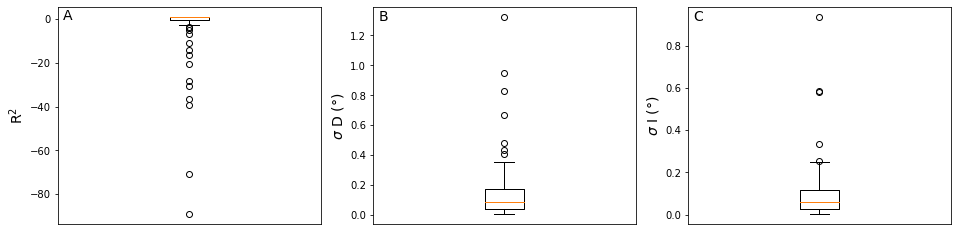

In [57]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
axes[0].boxplot(df_final['R2'])
axes[0].set_xticks([])
axes[0].set_ylabel('R$^2$', fontsize=14)
ytext = df_final['R2'].max()
axes[0].text(0.52, ytext-1.5*ytext, 'A', fontsize=14)

axes[1].boxplot(df_final['sigma D (°)'])
axes[1].set_xticks([])
axes[1].set_ylabel('$\sigma$ D (°)', fontsize=14)
ytext = df_final['sigma D (°)'].max()
axes[1].text(0.52, ytext-0.02*ytext, 'B', fontsize=14)

axes[2].boxplot(df_final['sigma I (°)'])
axes[2].set_xticks([])
axes[2].set_ylabel('$\sigma$ I (°)', fontsize=14)
ytext = df_final['sigma I (°)'].max()
axes[2].text(0.52, ytext-0.02*ytext, 'C', fontsize=14)

plt.show()

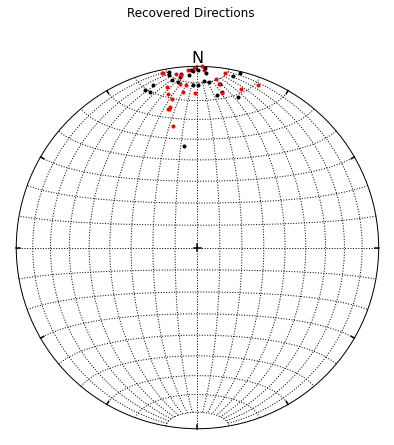

In [48]:
# index = ((df_final['R2']>=-np.inf) & (df_final['sigma D (°)']<=np.inf) & (df_final['sigma I (°)']<=np.inf)) # raw data
index = ((df_final['R2']>=0.5) & (df_final['sigma D (°)']<=5) & (df_final['sigma I (°)']<=3)) # filtered data
h=df_final[index]



D, I = directions(np.array(h['mx (Am2)']), np.array(h['my (Am2)']), np.array(h['mz (Am2)']), plot=True, show_mean=False, show_alpha95=False)

#### Momentum Recovered

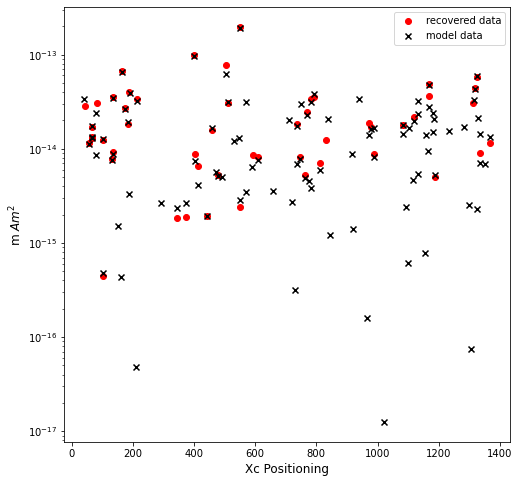

In [49]:
plt.figure(figsize=(8,8))
plt.scatter(h['Xc (µm)'], h['m (Am2)'], label='recovered data', color='r')

m_real = Q_1*4/3*np.pi*R_1**3
plt.scatter(Xc_1*m2microm, m_real, marker='x', label='model data', color='k')
plt.yscale('log')

plt.xlabel('Xc Positioning', fontsize=12)
plt.ylabel('m $Am^{2}$', fontsize=12)

plt.legend(loc='best')

# Article Figures

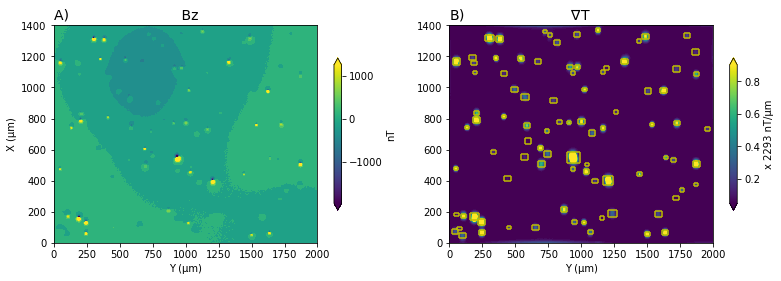

In [140]:
# create extent colorbars 
vmin1=np.min(d_*10**9) * 0.05
vmax1=np.max(d_*10**9) * 0.05
# vmin2=np.min(Total_Grad_FD*1.0e3) * 0.05
# vmax2=np.max(Total_Grad_FD*1.0e3) * 0.04
vmin2=0.05
vmax2=np.max(stretched_image) * 0.9

plt.figure(figsize=(.001,.001))
img1 = plt.imshow(d_*10**9, cmap='viridis')
img1.set_clim(vmin1, vmax1)
img2 = plt.imshow(d_*10**9, cmap='viridis')
img2.set_clim(vmin2, vmax2)
img2.axes.get_xaxis().set_visible(False)
img2.axes.get_yaxis().set_visible(False)

scale_max = int(np.max(Total_Grad_FD*10**3))





#### Real Figure ####
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(13,4))

# plot original data
ax1_plot = ax1.contourf(x_plot, y_plot, d_*10**9, levels=300, cmap='viridis', 
             vmin=vmin1, vmax=vmax1, extend='both')
color_bar1 = plt.colorbar(img1, ax=ax1, label='nT', extend='both', shrink=0.7)
ax1.set_title('A)                         Bz', fontsize=14, loc='left')
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)


# plot total gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='viridis',
                       vmin=vmin2, vmax=vmax2, extend='both')
color_bar2 = plt.colorbar(img2, ax=ax2, label='x %s nT/µm'%(str(scale_max)), extend='both', shrink=0.7)
ax2.set_title(r'B)                        $\nabla$T', fontsize=14, loc='left')
ax2.set_xlabel('Y (µm)', fontsize=10)
#ax2.set_ylabel('X (µm)', fontsize=10)


# plot isolated windows 
nx, ny = np.shape(d_)
y_step = (np.max(Y_)*m2microm - np.min(Y_)*m2microm) / (ny-1)
x_step = (np.max(X_)*m2microm - np.min(X_)*m2microm) / (nx-1)
color='y'
for i in range(np.shape(euler_windows_FD)[0]):
    x1 = int(euler_windows_FD[i,0]) * x_step
    x2 = int(euler_windows_FD[i,1]) * x_step
    y1 = int(euler_windows_FD[i,2]) * y_step
    y2 = int(euler_windows_FD[i,3]) * y_step

    plt.hlines(x1, y1, y2, color=color)
    plt.hlines(x2, y1, y2, color=color)
    plt.vlines(y1, x1, x2, color=color)
    plt.vlines(y2, x1, x2, color=color)
    
    
image_name = 'ComplexSynthetic'    
import os
my_path = os.path.abspath('') # Figures out the absolute path for you in case your working directory moves around.
fig.savefig(my_path + '\\..\\..\\images\\'+ image_name + '.png', dpi=600, facecolor='w', bbox_inches='tight')